<a id="TOP"></a>
# Workflow Demo

TBA
    
---
    
- Step 0: [Import Packages](#import_packages)
- Step 1: [Define the class to fill particle information in to NumpyArray](#define_class) 
- Step 2: [Define Functions](#define_function) 
- Step 3: [Define Function for `Event_List`](#event_list)  
- Step 4: [Import ROOT File](#import_file)
- Step 5: [Print the Branch in the Delphes](#delphes_tree)  
- Step 6: [Loading Event](#loading_event)
- Step 7: [Let's do Jet Clustering!!](#jet_clustering)
- Step 8: [Quick Check Jet Images](#jet_images)
- Step 9: [Quick check the $M_{JJ}$ of Higgs candidates](#quick_check_mjj)
- Step 10: [Quick Check Kinematics of Higgs candidates](#kinematics)
- Step 11: [Jet Trimmimng](#jet_trimming)
- Step 12: [di-Jet Events' Selection From Truth Record](#events_selection)
- Step 13: [High Level Features](#high_level_features)



- Step 14: [Print Jets in the Nth event](#jets_in_nth_event)
- Step 15: [Print the Truth Record in an Event](#truth_record)



---

[![arXiv](https://img.shields.io/badge/arXiv-1807.10768%20-green.svg)](https://arxiv.org/abs/1807.10768)   

[![arXiv](https://img.shields.io/badge/arXiv-2009.05930%20-green.svg)](https://arxiv.org/abs/2009.05930) 

Ref: [Boosting $H\to b\bar b$ with Machine Learning](https://arxiv.org/abs/1807.10768) 

Ref: [Disentangling Boosted Higgs Boson Production Modes with Machine Learning](https://arxiv.org/abs/2009.05930)  

Ref: [pyjet](https://github.com/scikit-hep/pyjet)   
    
---   
[Go to NBViewer](TBA)

<a id="import_packages"></a>
## Step 0: Import Packages
    
[Back to the top](#TOP)

In [2]:
import uproot
import pyjet
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import sys, os
import importlib
import time
import re 
import glob
from tqdm import tqdm
import h5py
import pyhf

import logging

importlib.reload(logging)
logging.basicConfig(level = logging.INFO)

from BranchClass import *

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
from matplotlib.collections import LineCollection
from matplotlib import cm

logging.info("Numpy Version: {}".format(np.__version__))
logging.info("Pnadas Version: {}".format(pd.__version__))
logging.info("uproot Version: {}".format(uproot.__version__))
logging.info("pyjet Version: {}".format(pyjet.__version__))
logging.info("pyhf version: {}".format(pyhf.__version__))

%config InlineBackend. figure_format = 'retina'

INFO:root:Numpy Version: 1.18.5
INFO:root:Pnadas Version: 1.1.4
INFO:root:uproot Version: 3.13.0
INFO:root:pyjet Version: 1.7.0
INFO:root:pyhf version: 0.6.3


<a id="define_class"></a>
## Step 1: Define the class to fill particle information in to NumpyArray     

    
 User can use 
```
GenParticles = BrachGenParticles(file)
PID_all = GenParticles.PID
```
to get all GenParticles PID array
or
```
GenParticles = BrachGenParticles(file)
PID = GenParticles.PID_At(i)
```
to get the GenParticles PID array in the ith event
    
More function can be found in `BranchClass.py`. 
    
[Back to the top](#TOP)

<a id="define_function"></a>
## Step 2: Define Functions 

[Back to the top](#TOP)

In [3]:
def M(pt1,eta1,phi1,m1,pt2,eta2,phi2,m2):
    px1, py1, pz1 = pt1*np.cos(phi1), pt1*np.sin(phi1), np.sqrt(m1**2+pt1**2)*np.sinh(eta1)
    e1 = np.sqrt(m1**2 + px1**2 + py1**2 + pz1**2)
    px2, py2, pz2 = pt2*np.cos(phi2), pt2*np.sin(phi2), np.sqrt(m2**2+pt2**2)*np.sinh(eta2)
    e2 = np.sqrt(m2**2 + px2**2 + py2**2 + pz2**2)
    
    return np.sqrt((e1+e2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2)

def Mbbbb(j1,j2,j3,j4):
    pt1, eta1, phi1, m1 = j1.pt,j1.eta,j1.phi,j1.mass
    pt2, eta2, phi2, m2 = j2.pt,j2.eta,j2.phi,j2.mass
    pt3, eta3, phi3, m3 = j3.pt,j3.eta,j3.phi,j3.mass
    pt4, eta4, phi4, m4 = j4.pt,j4.eta,j4.phi,j4.mass
    
    px1, py1, pz1 = pt1*np.cos(phi1), pt1*np.sin(phi1), np.sqrt(m1**2+pt1**2)*np.sinh(eta1)
    e1 = np.sqrt(m1**2 + px1**2 + py1**2 + pz1**2)
    px2, py2, pz2 = pt2*np.cos(phi2), pt2*np.sin(phi2), np.sqrt(m2**2+pt2**2)*np.sinh(eta2)
    e2 = np.sqrt(m2**2 + px2**2 + py2**2 + pz2**2)
    
    px3, py3, pz3 = pt3*np.cos(phi3), pt3*np.sin(phi3), np.sqrt(m3**2+pt3**2)*np.sinh(eta3)
    e3 = np.sqrt(m3**2 + px3**2 + py3**2 + pz3**2)
    px4, py4, pz4 = pt4*np.cos(phi4), pt4*np.sin(phi4), np.sqrt(m4**2+pt4**2)*np.sinh(eta4)
    e4 = np.sqrt(m4**2 + px4**2 + py4**2 + pz4**2)
    
    return np.sqrt((e1+e2+e3+e4)**2-(px1+px2+px3+px4)**2-(py1+py2+py3+py4)**2-(pz1+pz2+pz3+pz4)**2)

def MJJ(j1,j2):
    pt1, eta1, phi1, m1 = j1.pt,j1.eta,j1.phi,j1.mass
    pt2, eta2, phi2, m2 = j2.pt,j2.eta,j2.phi,j2.mass
    
    px1, py1, pz1 = pt1*np.cos(phi1), pt1*np.sin(phi1), np.sqrt(m1**2+pt1**2)*np.sinh(eta1)
    e1 = np.sqrt(m1**2 + px1**2 + py1**2 + pz1**2)
    px2, py2, pz2 = pt2*np.cos(phi2), pt2*np.sin(phi2), np.sqrt(m2**2+pt2**2)*np.sinh(eta2)
    e2 = np.sqrt(m2**2 + px2**2 + py2**2 + pz2**2)
    
    return np.sqrt((e1+e2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2)


def MT(pt1,eta1,phi1,m1,pt2,eta2,phi2,m2,missingET,missingETA,missingPHI):
    px1, py1, pz1 = pt1*np.cos(phi1), pt1*np.sin(phi1), np.sqrt(m1**2+pt1**2)*np.sinh(eta1)
    e1 = np.sqrt(m1**2 + px1**2 + py1**2 + pz1**2)
    px2, py2, pz2 = pt2*np.cos(phi2), pt2*np.sin(phi2), np.sqrt(m2**2+pt2**2)*np.sinh(eta2)
    e2 = np.sqrt(m2**2 + px2**2 + py2**2 + pz2**2)
    
    px_missing, py_missing = missingET*np.cos(missingPHI), missingET*np.sin(missingPHI)
    
    EllT = np.sqrt((px1+px2)**2 + (py1+py2)**2 +  M(pt1,eta1,phi1,m1,pt2,eta2,phi2,m2)**2 )

    MT = np.sqrt( (EllT+missingET)**2 - (px1+px2+px_missing)**2 - (py1+py2+py_missing)**2 )
    
    return MT
    
def PxPyPzE(pt,eta,phi,m):
    px, py, pz = pt*np.cos(phi), pt*np.sin(phi), np.sqrt(m**2+pt**2)*np.sinh(eta)
    e = np.sqrt(m**2 + px**2 + py**2 + pz**2)
    
    return px, py, pz, e    

def PtEtaPhiM(px, py, pz, e):
    E, px ,py, pz = e, px, py, pz  
    P = np.sqrt(px**2 + py**2 + pz**2)
    pt = np.sqrt(px**2 + py**2)
    eta = 1./2.*np.log((P + pz)/(P - pz))
    phi = np.arctan(py/px)
    m = np.sqrt(np.sqrt((E**2 - px**2 - py**2 - pz**2)**2))

    return pt, eta, phi, m

def ET(jet):
    pt = jet.pt
    m = jet.mass
    ET = np.sqrt(m**2 + pt**2)
    return  ET


def XHH(jet1, jet2):
    m1, m2 = jet1.mass, jet2.mass
    XHH = np.sqrt( (m1-124)**2/(0.1*m1) + (m2-115)**2/(0.1*m2))
    return  XHH

def DeltaR(eta1,phi1, eta2,phi2):
    dEta = eta1-eta2
    dPhi = abs(phi1-phi2)
    if dPhi > np.pi:
        dPhi = 2*np.pi - dPhi

    dR = (dPhi**2 + dEta**2)**0.5

    return dR

def FourVectorbb(pt1,eta1,phi1,m1,pt2,eta2,phi2,m2):
    px1, py1, pz1 = pt1*np.cos(phi1), pt1*np.sin(phi1), np.sqrt(m1**2+pt1**2)*np.sinh(eta1)
    e1 = np.sqrt(m1**2 + px1**2 + py1**2 + pz1**2)
    px2, py2, pz2 = pt2*np.cos(phi2), pt2*np.sin(phi2), np.sqrt(m2**2+pt2**2)*np.sinh(eta2)
    e2 = np.sqrt(m2**2 + px2**2 + py2**2 + pz2**2)
    
    m = np.sqrt((e1+e2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2)
    pt = np.sqrt((px1+px2)**2 + (py1+py2)**2)
    eta = np.arcsinh((pz1+pz2)/np.sqrt(m**2+pt**2))
    phi = np.arcsin((py1+py2)/pt)
    
    return pt, eta, phi, m


def jet_trim(jet0, pt_cut= 0.05, R1 = 0.2):
    # Define a cut threshold that the subjets have to meet (i.e. 3% of the original jet pT)
    jet0_max = jet0.pt
    jet0_cut = jet0_max*pt_cut

    # Grab the subjets by clustering with R1
    subjets = pyjet.cluster(jet0.constituents_array(), R=R1, p=1) # p = -1: anti-kt , 0: Cambridge-Aachen(C/A), 1: kt
    subjet_array = subjets.inclusive_jets()
    j0 = []
    if (subjet_array[0].pt >= jet0_cut):
        for ij, subjet in enumerate(subjet_array):
            if subjet.pt < jet0_cut:
                # subjet doesn't meet the percentage cut on the original jet pT
                continue
            if subjet.pt >= jet0_cut:
                # Get the subjets pt, eta, phi constituents
                subjet_data = subjet.constituents_array()
                j0.append(subjet_data)
    else:
        j0 = subjet_array[0].constituents_array()*0
    jet = j0[0]
    for i, subjet in enumerate(j0):
        if i==0 :
            continue
        jet = np.append(jet, subjet)
        
    sequence = pyjet.cluster(jet, R=1.0, p=-1)
    jet = sequence.inclusive_jets()
    return jet


def digit(loc,pid):
    #     //  PID digits (base 10) are: n nr nl nq1 nq2 nq3 nj
    #     //   nj = 1, nq3=2 , nq2=3, nq1, nl, nr, n, n8, n9, n10 
    #     //  the location enum provides a convenient index into the PID
    numerator = 10**(loc-1)
    
    return int((abs(pid)/numerator)%10)

def hasBottom(pid):
    # get B hadron
    # PID for B hadron are 5XX, 5XXX
    # https://gitlab.com/hepcedar/rivet/-/blob/release-3-1-x/analyses/pluginCMS/CMS_2015_I1370682.cc#L390
    # https://rivet.hepforge.org/code/2.1.0/a00827.html#ad4c917595339ea52152c2950ce1225e7
    # https://pdg.lbl.gov/2019/reviews/rpp2019-rev-monte-carlo-numbering.pdf
    if( digit(2,pid) == 5 or digit(3,pid) == 5 or digit(4,pid) == 5 ):
        return True
    else:
        return False



<a id="event_list"></a>
## Step 3: Define Function for `Event_List`

[Back to the top](#TOP)

In [5]:
def Event_List(GenParticle, EventWeight):
#     logging.info(time.strftime("%a %b %d %H:%M:%S %Y", time.localtime()))
    ticks_1 = time.time()
    
    k = 0
    bbbb_list = []
    event_list = []
    bb1_P4, bb2_P4 = [], []
    Mbbbb = []
    bhadron_list = []
    for N in tqdm(range(GenParticle.length)):

        event_list_tmp = []
        
        event_list_tmp.append([GenParticle.PT_At(N),  GenParticle.Eta_At(N), \
                               GenParticle.Phi_At(N), GenParticle.Mass_At(N), \
                               GenParticle.PID_At(N), GenParticle.Status_At(N),\
                               GenParticle.Charge_At(N),\
                               np.full(len(GenParticle.PT_At(N)),0), #for B hadron tag
                               np.full(len(GenParticle.PT_At(N)), EventWeight.Event_Weight_At(N)[0]),
                               GenParticle.M1_At(N), GenParticle.M2_At(N),\
                               GenParticle.D1_At(N), GenParticle.D2_At(N),\
                               
                              ])
        
        event_list_tmp = np.array(event_list_tmp)
    
        """
        Find All B Hadrons
        """
        unstable_hadron = event_list_tmp[0][:,np.abs(event_list_tmp[0][5,:])==2]
        bhadron_index = np.where(np.vectorize(hasBottom)(unstable_hadron[4,:])==True)[0] 
        bhadron = unstable_hadron[:,bhadron_index]
        bhadron_list_tmp = []
        
        """
        Find B Hadrons before decay
        """
        for i in range(len(bhadron[0])):   
            if hasBottom(GenParticle.PID_At(N)[int(bhadron[11][i])]) == False and hasBottom(GenParticle.PID_At(N)[int(bhadron[12][i])]) == False:
                bhadron_list_tmp.append(bhadron[:,i])
        
        """
        Ghost Association Method: create ghost-associated B Hadrons
        """
        Ghostparam = 1E-20
        for i, element in enumerate(bhadron_list_tmp):
            bhadron_list_tmp[i][0] = element[0]*Ghostparam  # PT*Ghostparam
            bhadron_list_tmp[i][3] = element[3]*Ghostparam  # Mass*Ghostparam
            bhadron_list_tmp[i][7] = 1                      #B Hadron tag 
        
        """
        Pick stable final state particel (status = 1) and filter ou neutrinos (|PID| = 12, 14, 16)
        """
        event_list_tmp = event_list_tmp[0][:,event_list_tmp[0][5,:]==1] 
        event_list_tmp = event_list_tmp[:,np.abs(event_list_tmp[4,:])!=12]
        event_list_tmp = event_list_tmp[:,np.abs(event_list_tmp[4,:])!=14]
        event_list_tmp = event_list_tmp[:,np.abs(event_list_tmp[4,:])!=16]
        
        """
        Ghost Association Method: add ghost-associated B Hadrons
        """
        if len(bhadron_list_tmp) != 0:
            event_list_tmp = np.concatenate((np.array(event_list_tmp).transpose(),bhadron_list_tmp)).transpose()
            
        else:
            event_list_tmp = np.array(event_list_tmp)
        
        event_list.append(event_list_tmp)
        
        
        k += 1
        if k == 10000:
            break
        
    ticks_2 = time.time()
    totaltime =  ticks_2 - ticks_1
    logging.info("\033[3;33mTime Cost : {:.4f} min\033[0;m".format(totaltime/60.))
    
    return event_list

<a id="import_file"></a>
## Step 4: Import ROOT File

[Back to the top](#TOP)

In [6]:
%%time

path = "/home/u5/THDM/"



def loading_root_file(dictinary = {},  process_path = []) -> dict:
    
    if len(process_path) == 0:
        raise ValueError("Please Check Input Path!!!")
    else:
        pass
    
    """
    Create Dictinary
    """
    for nth_file in range(len(process_path)):
        dictinary.update({"file_"+str(nth_file+1): 0})
    
    """
    Put ROOT File into Dictinary
    """
    logging.info("\n")  
    for file_path, nth_file in zip(process_path, dictinary):

        if os.path.isfile(file_path):
            logging.info(str(file_path) +" exists.")

            dictinary[nth_file] = uproot.open(file_path)["Delphes;1"]

        else:
            logging.info("Please Check Input Files!!!" + str(file_path))
            raise ValueError("Please Check Input Files!!!" + str(file_path))
            
    return dictinary




"""
Signal
"""
process_path_ppHhh = sorted(glob.glob(path+"proc_ppHhh/Events/run_0*_*/" +"tag_1_delphes_events.root"))

signal_ppHhh = loading_root_file(dictinary = {}, process_path = process_path_ppHhh)



# """
# Backgound
# """
# process_path_ttbar = sorted(glob.glob(path+"proc_ttbar/Events/run_0*/" +"tag_1_delphes_events.root"))
# process_path_ppbbbb = sorted(glob.glob(path+"proc_ppbbbb/Events/run_0*/" +"tag_1_delphes_events.root"))
# process_path_jjjj = sorted(glob.glob(path+"proc_jjjj/Events/run_0*/" +"tag_1_delphes_events.root"))


# bkg_ttbar = loading_root_file(dictinary = {}, process_path = process_path_ttbar)
# bkg_ppbbbb = loading_root_file(dictinary = {}, process_path = process_path_ppbbbb)
# bkg_jjjj = loading_root_file(dictinary = {}, process_path = process_path_jjjj)


        
logging.info("\n")
logging.info("All Files are loaded!")
    


INFO:root:

INFO:root:/home/u5/THDM/proc_ppHhh/Events/run_01_decayed_1/tag_1_delphes_events.root exists.
INFO:root:

INFO:root:All Files are loaded!


CPU times: user 863 ms, sys: 37.5 ms, total: 900 ms
Wall time: 1.02 s


<a id="delphes_tree"></a>
## Step 5: Print the Branch in the Delphes

[Back to the top](#TOP)

In [19]:
# signal_ppHhh["file_1"].show()

<a id="loading_event"></a>
## Step 6: Loading Event 

[Back to the top](#TOP)

In [8]:
%%time
def Loading_Event(ROOT_dictionary = []):

    Event_List_, Event_Weight_ = [], []
    for nth_file in ROOT_dictionary:
        logging.info("File: {}".format(nth_file))
        
        GenParticle = BranchGenParticles(ROOT_dictionary[nth_file])
        Jet = BranchJet(ROOT_dictionary[nth_file])
        Event_Weight_tmp = Event_Weight(ROOT_dictionary[nth_file])
        Event_List_tmp = Event_List(GenParticle, Event_Weight_tmp)
        

        Event_List_.extend(Event_List_tmp)
        Event_Weight_.extend(Event_Weight_tmp.Event_Weight)
        logging.info("\n")
    
    return Event_List_, Event_Weight_
    

Event_List_Signal_ppHhh, Weight_Signal_ppHhh = Loading_Event(signal_ppHhh)
# Event_List_Bkg_ttbar, Weight_Bkg_ttbar = Loading_Event(bkg_ttbar)
# Event_List_Bkg_ppbbbb, Weight_Bkg_ppbbbb = Loading_Event(bkg_ppbbbb)
# Event_List_Bkg_jjjj, Weight_Bkg_jjjj = Loading_Event(bkg_jjjj)


INFO:root:File: file_1
 10%|▉         | 9999/100000 [00:13<02:02, 736.53it/s]
INFO:root:Time Cost : 0.2263 min
INFO:root:



CPU times: user 58.8 s, sys: 4.23 s, total: 1min 3s
Wall time: 1min 24s


<a id="jet_clustering"></a>
## Step 7: Let's do Jet Clustering!!
### We use ` np.core.records.fromarrays` to assign the name of kinematic variables and PID
### In `pyjet`, the data type are only 
`
np.dtype([('pT', 'f8'), ('eta', 'f8'), ('phi', 'f8'), ('mass', 'f8')])
`
### or (cluster(..., ep=True))
`
np.dtype([('E', 'f8'), ('px', 'f8'), ('py', 'f8'), ('pz', 'f8')])  
`
### In this example, we use `(pt, eta, phi and mass)`.
### After assigning the name for our each event list, the `pyjet.cluster` and `inclusive_jets` will help us do jet clustering.
`
sequence_cluster = pyjet.cluster(to_cluster, R = 1.0,p = -1)
jets_cluster = sequence_cluster.inclusive_jets(pt_min)
`
#### Variable: `R` is the cone size of the jet.
#### Variable: `p` is the jet clustering algorithm. `-1: anti-kt , 0: Cambridge-Aachen(C/A), 1: kt`
#### Variable: `pt_min` is the minimum jet's pt.

[Back to the top](#TOP)

In [9]:
%%time
ticks_1 = time.time()

process_list = {"Event_List_Signal_ppHhh":Event_List_Signal_ppHhh, 
                # "Event_List_Bkg_ttbar":Event_List_Bkg_ttbar, 
                # "Event_List_Bkg_ppbbbb":Event_List_Bkg_ppbbbb, 
                # "Event_List_Bkg_jjjj":Event_List_Bkg_jjjj
                }



mc_data = ["ppHhh"]#, "ttbar", "ppbbbb", "ppjjjj"]

# hf_read = h5py.File("./EventList_H_pythia_def_250_500_1.h5", 'r')
# process_list = {"test":hf_read, }
# mc_data = ["test"]

clustering_dict = {}
for name in mc_data:
    clustering_dict.update({str(name):{"process_list_clustered":[], 
                                       "Higgs_candidate_4b":[],
                                       "four_b_tag":[],
                                       "four_b_raw_weight":[],
                                       "Higgs_candidate_3b":[], 
                                       "three_b_tag":[],    
                                       "three_b_raw_weight":[],
                                       "Higgs_candidate_2b":[],
                                       "two_b_tag":[],
                                       "two_b_raw_weight":[]},})



for N, (process, clustering) in enumerate(zip(process_list,clustering_dict)):
    counter = 0
    logging.info("Event List: {}, MC Name: {}".format(process, clustering))
    
    for i in tqdm(range(len(process_list[process]))):
        time.sleep(0.2)

        """
        Jet clustering 
        Fat jet: R = 1
        Anti-kt
        """
        to_cluster = np.core.records.fromarrays(process_list[process][i][:9], 
                                                names="pt, eta, phi, mass, PID, Status, Charge, B_tag, weight",
                                                formats = "f8, f8, f8, f8, f8, f8, f8, f8, f8"
                                               )
        
        
        pt_min = 25
        sequence_cluster = pyjet.cluster(to_cluster, R = 1, p = -1) # p = -1: anti-kt , 0: Cambridge-Aachen(C/A), 1: kt
        jets_cluster = sequence_cluster.inclusive_jets(pt_min)
        clustering_dict[clustering]["process_list_clustered"].append(jets_cluster)

        
        

        """
        4b category: have two b-tagged jets associated with each $H$ candidate
        """
        Higgs_candidate_tmp = []
        if len(jets_cluster) >=2:
            for jet in jets_cluster[:2]:
                B_tag = 0
                for constituent in jet:
                    if constituent.B_tag == 1:
                        B_tag += 1
                if B_tag >= 2:
                    Higgs_candidate_tmp.append(jet)

        if len(Higgs_candidate_tmp) >= 2:
            clustering_dict[clustering]["Higgs_candidate_4b"].append(Higgs_candidate_tmp)
            clustering_dict[clustering]["four_b_tag"].append(1)
            for constituent in Higgs_candidate_tmp[0]:
                clustering_dict[clustering]["four_b_raw_weight"].append(constituent.weight)
                break

        else:
            clustering_dict[clustering]["four_b_tag"].append(0)


        """
        3b category: have two $b$-tagged jets associated with one $H$ candidate 
        and exactly one $b$-tagged jet associated with the other $H$ candidate.
        """
        Higgs_candidate_tmp_2b, Higgs_candidate_tmp_1b = [], []
        if len(jets_cluster) >=2:
            B_tag = 0
            for constituent in jets_cluster[0]:
                if constituent.B_tag == 1:
                    B_tag += 1
            if B_tag >= 2:
                Higgs_candidate_tmp_2b.append(jets_cluster[0])

            B_tag = 0
            for constituent in jets_cluster[1]:
                if constituent.B_tag == 1:
                    B_tag += 1
            if B_tag >= 2:
                Higgs_candidate_tmp_2b.append(jets_cluster[1])

            B_tag = 0
            for constituent in jets_cluster[0]:
                if constituent.B_tag == 1:
                    B_tag += 1
            if B_tag == 1:
                Higgs_candidate_tmp_1b.append(jets_cluster[0])

            B_tag = 0  
            for constituent in jets_cluster[1]:
                if constituent.B_tag == 1:
                    B_tag += 1
            if B_tag == 1:
                Higgs_candidate_tmp_1b.append(jets_cluster[1])


        if len(Higgs_candidate_tmp_2b) == 1 and len(Higgs_candidate_tmp_1b) == 1:
            clustering_dict[clustering]["Higgs_candidate_3b"].append([Higgs_candidate_tmp_2b[0],Higgs_candidate_tmp_1b[0]])
            clustering_dict[clustering]["three_b_tag"].append(1)
            for constituent in Higgs_candidate_tmp[0]:
                clustering_dict[clustering]["three_b_raw_weight"].append(constituent.weight)
                break

        else:
            clustering_dict[clustering]["three_b_tag"].append(0)


        """
        2b category: have exactly one $b$-tagged jet associated with each $H$ candidate
        """
        Higgs_candidate_tmp = []
        if len(jets_cluster) >=2:
            for jet in jets_cluster[:2]:
                B_tag = 0
                for constituent in jet:
                    if constituent.B_tag == 1:
                        B_tag += 1
                if B_tag == 1:
                    Higgs_candidate_tmp.append(jet)

        if len(Higgs_candidate_tmp) >= 2:
            clustering_dict[clustering]["Higgs_candidate_2b"].append(Higgs_candidate_tmp)
            clustering_dict[clustering]["two_b_tag"].append(1)
            for constituent in Higgs_candidate_tmp[0]:
                clustering_dict[clustering]["two_b_raw_weight"].append(constituent.weight)
                break

        else:
            clustering_dict[clustering]["two_b_tag"].append(0)
        
        
        counter += 1 
        if counter == 10000:
            break



ticks_2 = time.time()
totaltime =  ticks_2 - ticks_1
logging.info("\033[3;33mTime Cost : {:.4f} min\033[0;m".format(totaltime/60.))

INFO:root:Event List: Event_List_Signal_ppHhh, MC Name: ppHhh
 31%|███       | 3088/10000 [11:54<26:38,  4.32it/s]


KeyboardInterrupt: 

In [ ]:
%%time
for clustering in clustering_dict:

    logging.info("Process: {}".format(clustering))
    logging.info("There are {} events (process_list_clustered).".format(len(clustering_dict[clustering]["process_list_clustered"])))
    logging.info("There are {} events (4b Higgs Candidate).".format(len(clustering_dict[clustering]["Higgs_candidate_4b"])))
    logging.info("There are {} events (3b Higgs Candidate).".format(len(clustering_dict[clustering]["Higgs_candidate_3b"])))
    logging.info("There are {} events (2b Higgs Candidate).".format(len(clustering_dict[clustering]["Higgs_candidate_2b"])))
    logging.info("\n")




INFO:root:Process: ppHhh
INFO:root:There are 10000 events (process_list_clustered).
INFO:root:There are 5262 events (4b Higgs Candidate).
INFO:root:There are 2535 events (3b Higgs Candidate).
INFO:root:There are 851 events (2b Higgs Candidate).
INFO:root:

INFO:root:Process: ttbar
INFO:root:There are 10000 events (process_list_clustered).
INFO:root:There are 10 events (4b Higgs Candidate).
INFO:root:There are 124 events (3b Higgs Candidate).
INFO:root:There are 1750 events (2b Higgs Candidate).
INFO:root:

INFO:root:Process: ppbbbb
INFO:root:There are 10000 events (process_list_clustered).
INFO:root:There are 1018 events (4b Higgs Candidate).
INFO:root:There are 4184 events (3b Higgs Candidate).
INFO:root:There are 4305 events (2b Higgs Candidate).
INFO:root:

INFO:root:Process: ppjjjj
INFO:root:There are 10000 events (process_list_clustered).
INFO:root:There are 18 events (4b Higgs Candidate).
INFO:root:There are 30 events (3b Higgs Candidate).
INFO:root:There are 53 events (2b Higgs 

CPU times: user 30.9 ms, sys: 0 ns, total: 30.9 ms
Wall time: 24.7 ms


<a id="jet_images"></a>
# Step 8: Quick Check Jet Images

[Back to the top](#TOP)

In [39]:
def dphi(phi,phi_c):

    dphi_temp = phi - phi_c
    while dphi_temp > np.pi:
        dphi_temp = dphi_temp - 2*np.pi
    while dphi_temp < -np.pi:
        dphi_temp = dphi_temp + 2*np.pi
    return (dphi_temp)


###################################################################################
logging.info("Make Leading Jet Images")
logging.info("\n")    
logging.info(time.strftime("%a %b %d %H:%M:%S %Y", time.localtime()))
time.sleep(1)
ticks_1 = time.time()

jetimage_list = []

image_source = clustering_dict["ppHhh"]["Higgs_candidate_4b"]

for N in tqdm(range(len(image_source))):
    
    if len(image_source[N]) < 1: # at least one jet in this event.
        continue 
        

    
    jet = image_source[N][0] #leading jet's information
    

    width,height = 40,40
    image_0 = np.zeros((width,height)) #Charged pt 
    image_1 = np.zeros((width,height)) #Neutral pt
    image_2 = np.zeros((width,height)) #Charged multiplicity
    isReflection = 1
    x_hat = np.array([1,0]) 
    y_hat = np.array([0,1])
    
    subjets = pyjet.cluster(jet.constituents_array(), R=0.2, p=-1)
    subjet_array = subjets.inclusive_jets()
    
        
    if len(subjet_array) > 1:
            #First, let's find the direction of the second-hardest jet relative to the first-hardest jet
#             phi_dir = -(dphi(subjet_array[1].phi,subjet_array[0].phi))
#             eta_dir = -(subjet_array[1].eta - subjet_array[0].eta)
            phi_dir = -(dphi(subjet_array[1].phi,jet.phi))
            eta_dir = -(subjet_array[1].eta - jet.eta)
            #Norm difference:
            norm_dir = np.linalg.norm([phi_dir,eta_dir])
            #This is now the y-hat direction. so we can actually find the unit vector:
            y_hat = np.divide([phi_dir,eta_dir],np.linalg.norm([phi_dir,eta_dir]))
            #and we can find the x_hat direction as well
            x_hat = np.array([y_hat[1],-y_hat[0]]) 
    
    if len(subjet_array) > 2:
#         phi_dir_3 = -(dphi(subjet_array[2].phi,subjet_array[0].phi))
#         eta_dir_3 = -(subjet_array[2].eta - subjet_array[0].eta)
        phi_dir_3 = -(dphi(subjet_array[2].phi,jet.phi))
        eta_dir_3 = -(subjet_array[2].eta - jet.eta)

        isReflection = np.cross(np.array([phi_dir,eta_dir,0]),np.array([phi_dir_3,eta_dir_3,0]))[2]
        

    R = 1.0
    for constituent in jet:
        
#         new_coord = [dphi(constituent.phi,jet.phi),constituent.eta-jet.eta]
#         indxs = [math.floor(width*new_coord[0]/(R*1.5))+width//2, math.floor(height*(new_coord[1])/(R*1.5))+height//2]


        if (len(subjet_array) == 1):
            #In the case that the reclustering only found one hard jet (that seems kind of bad, but hey)
            #no_two = no_two+1
#             new_coord = [dphi(constituent.phi,subjet_array[0].phi),constituent.eta-subjet_array[0].eta]
            new_coord = [dphi(constituent.phi, jet.phi),constituent.eta-jet.eta]
            logging.info(constituent.eta, jet.eta)
            logging.info(new_coord)
            indxs = [math.floor(width*new_coord[0]/(R*1))+width//2, math.floor(height*(new_coord[1])/(R*1))+height//2]
            
        else:
            #Now, we want to express an incoming particle in this new basis:
#             part_coord = [dphi(constituent.phi,subjet_array[0].phi),constituent.eta-subjet_array[0].eta]
            part_coord = [dphi(constituent.phi,jet.phi),constituent.eta-jet.eta]
            new_coord = np.dot(np.array([x_hat,y_hat]),part_coord)
            
            #put third-leading subjet on the right-hand side
            if isReflection < 0: 
                new_coord = [-new_coord[0],new_coord[1]]
            elif isReflection > 0:
                new_coord = [new_coord[0],new_coord[1]]
            #Now, we want to cast these new coordinates into our array
            #(row,column)
#             indxs = [math.floor(width*new_coord[0]/(R*1.5))+width//2,math.floor(height*(new_coord[1]+norm_dir/1.5)/(R*1.5))+height//2]
#             indxs = [math.floor(width*new_coord[0]/(R*1.5))+width//2,math.floor(height*new_coord[1]/(R*1.5))+height//2] #(phi,eta) and the leading subjet at the origin
#             indxs = [math.floor(height*new_coord[1]/(R*1.5))+height//2,math.floor(width*new_coord[0]/(R*1.5))+width//2] #(eta,phi) and the leading subjet at the origin
            indxs = [math.floor(height*new_coord[1]/(R*1))+height//2,math.floor(width*new_coord[0]/(R*1))+width//2] #(eta,phi) and the leading subjet at the origin

        if indxs[0] >= width or indxs[1] >= height or indxs[0] <= 0 or indxs[1] <= 0:
            continue
            
        phi_index = int(indxs[0]); eta_index = int(indxs[1])

        #finally, let's fill
        if constituent.Charge != 0:
            image_0[phi_index,eta_index] = image_0[phi_index,eta_index] + constituent.pt
            image_2[phi_index,eta_index] = image_2[phi_index,eta_index] + 1

        elif constituent.Charge == 0:
            image_1[phi_index,eta_index] = image_1[phi_index,eta_index] + constituent.pt

            
    image_0 = np.divide(image_0,np.sum(image_0)) #Charged pt 
    image_1 = np.divide(image_1,np.sum(image_1)) #Neutral pt 
    image_2 = np.divide(image_2,np.sum(image_2)) #Charged multiplicity
    jetimage_list.append(np.array([image_0,image_1,image_2]))
    
    
jetimage_list = np.array(jetimage_list)


logging.info("There are {} jet images.".format(len(jetimage_list)))

# np.savez(imagespath +str(PRO)+"_"+str(GEN)+"_"+str(SHO)+"_"+str(file_number)+"_untrimmed.npz", jetimage_list)

ticks_2 = time.time()
totaltime =  ticks_2 - ticks_1
logging.info("\033[3;33mTime Cost : {:.4f} min\033[0;m".format(totaltime/60.))





INFO:root:Make Leading Jet Images
INFO:root:

INFO:root:Mon Oct 18 13:22:51 2021
100%|██████████| 5262/5262 [00:08<00:00, 599.67it/s]
INFO:root:There are 5262 jet images.
INFO:root:Time Cost : 0.1480 min


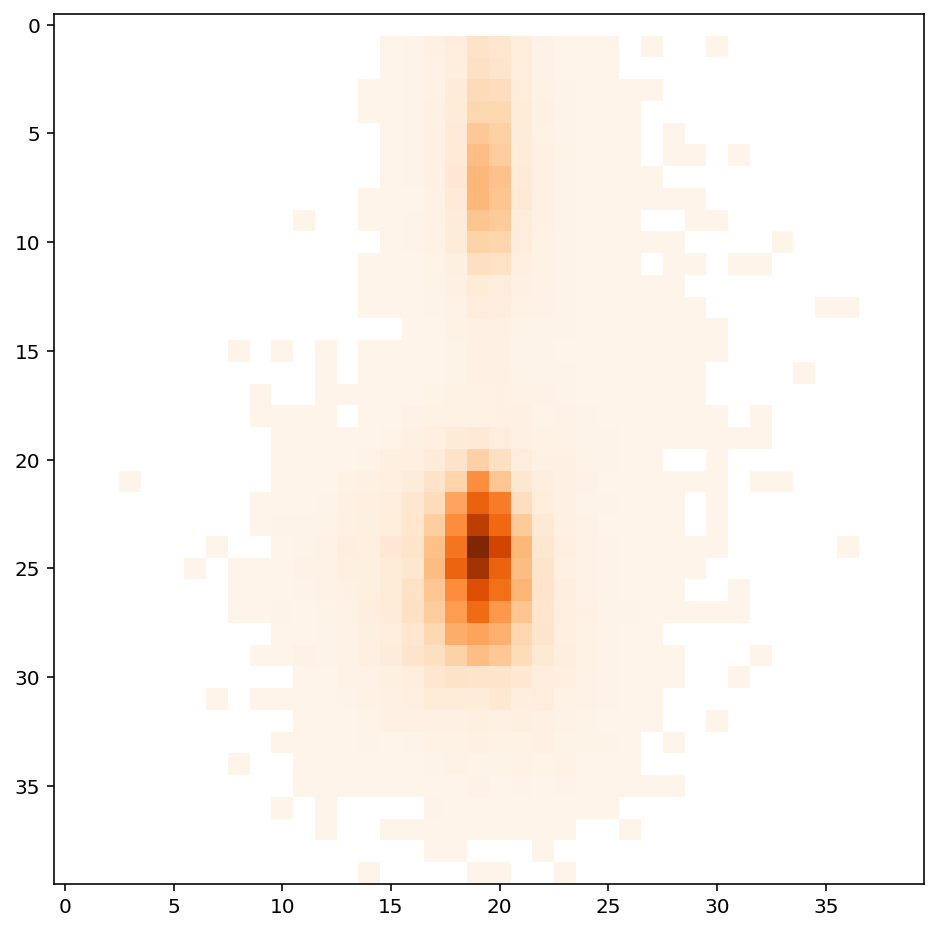

In [40]:
Oranges = cm.get_cmap('Oranges_r', 256)
newcolors = Oranges(np.linspace(1, 0, 256))
white = np.array([256/256, 256/256, 256/256, 1])
newcolors[:1, :] = white
newcmap = ListedColormap(newcolors, name='OrangeWhite')

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))


plt.imshow(np.average(jetimage_list[:,0], axis=0),vmin=0, 
#                            vmax=round(np.max(jetimage_average),3),
#                           vmax=0.5,
                          cmap=newcmap, 
                           origin='upper')

plt.show()

<a id="quick_check_mjj"></a>
# Step 9: Quick check the $M_{JJ}$ of Higgs candidates


[Back to the top](#TOP)

In [43]:
%%time 


mc_data = ["ppHhh", "ttbar", "ppbbbb", "ppjjjj"]

kinematic_plots = {}
for name in mc_data:
    kinematic_plots.update({str(name):{"M_h1":[],"M_h2":[],"M_JJ":[],}})


for clustering in clustering_dict:
    for i, element in enumerate(clustering_dict[clustering]["Higgs_candidate_4b"]):
        if len(element) < 2:
            continue
        kinematic_plots[clustering]["M_h1"].append(element[0].mass)
        kinematic_plots[clustering]["M_h2"].append(element[1].mass)
        kinematic_plots[clustering]["M_JJ"].append(MJJ(element[0],element[1]))
        
    logging.info("Process: {}, # of events: {}".format(clustering, len(kinematic_plots[clustering]["M_JJ"])))

INFO:root:Process: ppHhh, # of events: 5262
INFO:root:Process: ttbar, # of events: 10
INFO:root:Process: ppbbbb, # of events: 1018
INFO:root:Process: ppjjjj, # of events: 18


CPU times: user 220 ms, sys: 0 ns, total: 220 ms
Wall time: 216 ms


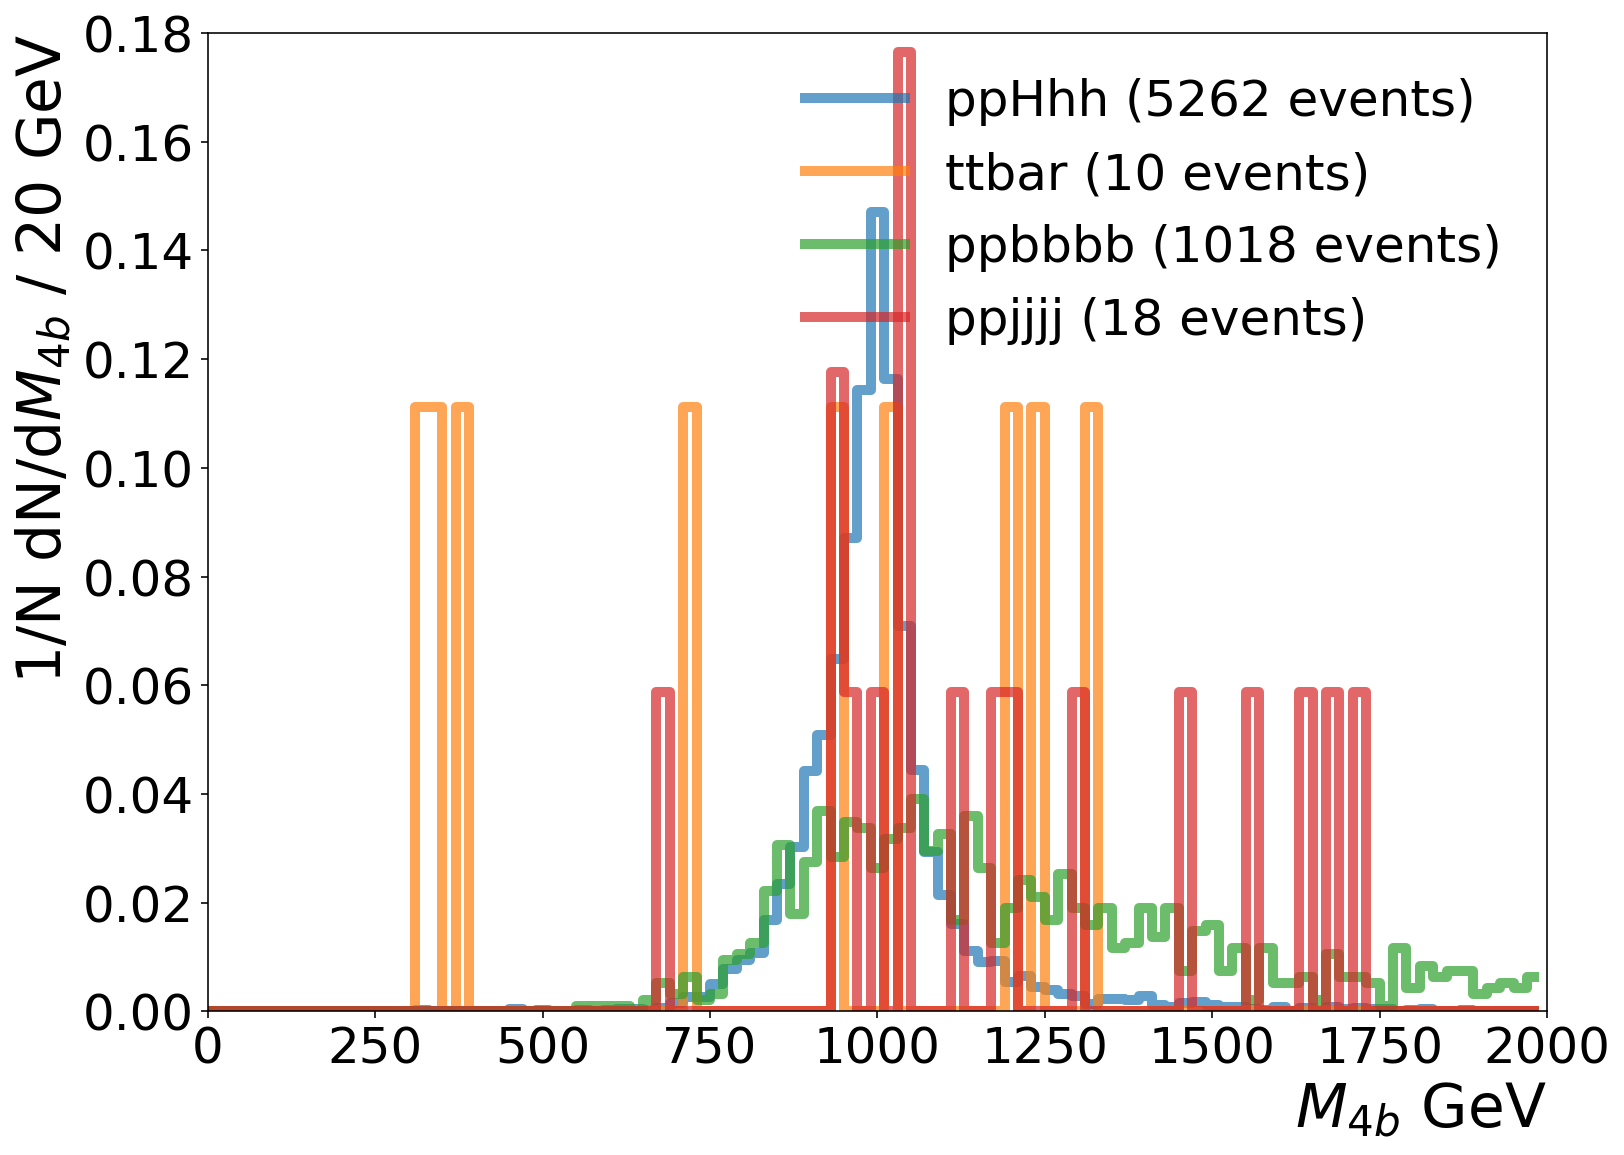

In [44]:
fig, ax = plt.subplots(1,1, figsize=(12,9))
length = np.linspace(0,2000,101)


for element in kinematic_plots:
    hist, bins = np.histogram(kinematic_plots[element]["M_JJ"], bins=length)
    plt.step(bins[:-1], 
             hist.astype(np.float32) / hist.sum() ,
             where='mid',
             linewidth=5, 
             alpha=0.7,
             label="{} ({} events)".format(element,len(kinematic_plots[element]["M_JJ"])))


ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
plt.xlim((0,2000))
plt.xlabel("$M_{4b}$ GeV", fontsize=30,horizontalalignment='right',x=1) 

plt.legend(loc="upper right",ncol=1,fontsize=25, edgecolor = "w",fancybox=False, framealpha=0)
    
plt.ylim((0., 0.18))
plt.ylabel("1/N dN/d$M_{4b}$ / 20 GeV", fontsize=30, horizontalalignment='right',y=1)
plt.show() 

<a id="kinematics"></a>
# Step 10: Quick Check Kinematics of Higgs candidates


[Back to the top](#TOP)

In [64]:
%%time

M_h = []
PT_h = []
weight = []

for i in range(len(Higgs_candidate_4b)):
    M_h.append([])
    PT_h.append([])
    weight.append([])
    
for N, process in enumerate(Higgs_candidate_4b):
# for N, process in enumerate(process_list_clustered):
    for i, element in tqdm(enumerate(process)):
        if len(element) < 1:
            continue
        M_h[N].append(element[0].mass)
        PT_h[N].append(element[0].pt)
        weight[N].append(four_b_raw_weight[N][i])
        
    if N == 0:
        proc = "H signal"
    else:
        proc = "bkg"

    logging.info("Process: {}, # of events:{}".format(proc,len(PT_h[N])))
    logging.info("\n")
    

5262it [00:00, 104218.86it/s]
INFO:root:Process: H signal, # of events:5262
INFO:root:

10it [00:00, 40721.40it/s]
INFO:root:Process: bkg, # of events:10
INFO:root:

1018it [00:00, 77026.35it/s]
INFO:root:Process: bkg, # of events:1018
INFO:root:

18it [00:00, 64143.99it/s]
INFO:root:Process: bkg, # of events:18
INFO:root:



CPU times: user 53.9 ms, sys: 28.1 ms, total: 82 ms
Wall time: 77.6 ms


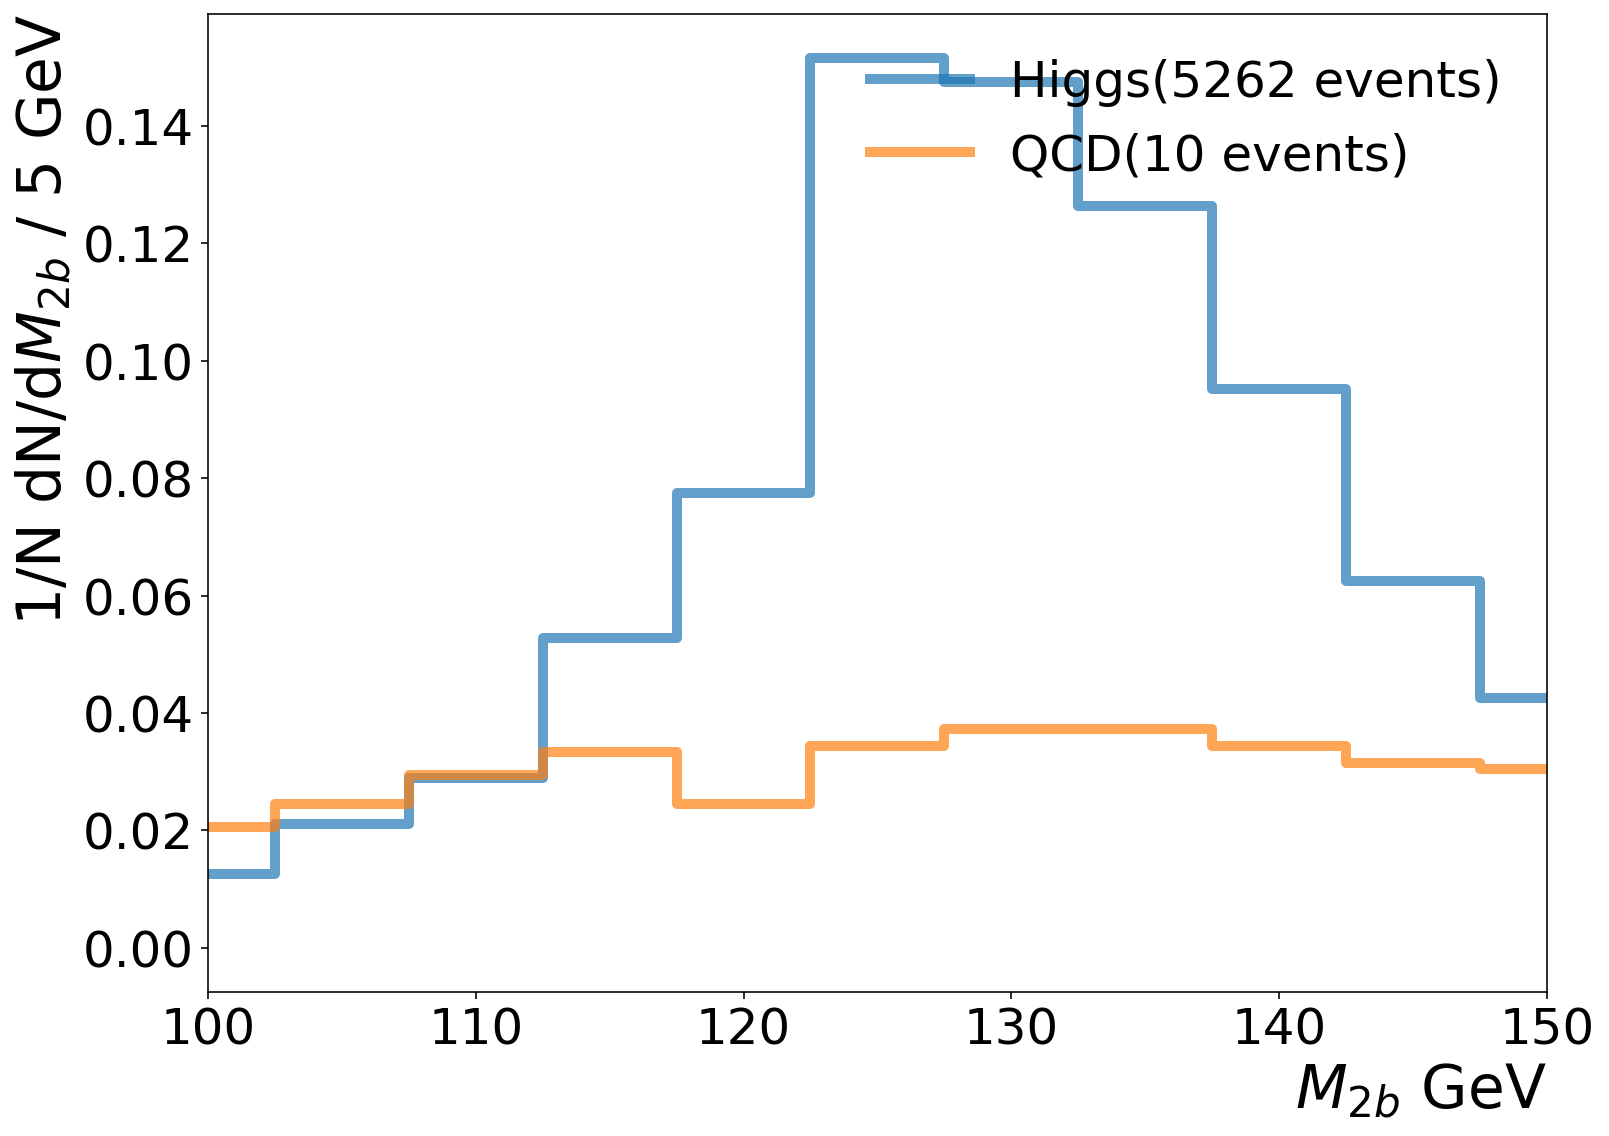

CPU times: user 553 ms, sys: 28.2 ms, total: 581 ms
Wall time: 577 ms


In [70]:
%%time

fig, ax = plt.subplots(1,1, figsize=(12,9))
length = np.linspace(0,2000,401)


index = 0

hist, bins = np.histogram(M_h[index], bins=length)#, weights=weight[index])
plt.step(bins[:-1], 
         hist.astype(np.float32) / hist.sum() ,
#          hist.astype(np.float32) ,
         where='mid',
         linewidth=5, 
         alpha=0.7,
         label="Higgs({} events)".format(len(M_h[0])))

index = 2

hist, bins = np.histogram(M_h[index], bins=length)#, weights=weight[index])
plt.step(bins[:-1], 
         hist.astype(np.float32) / hist.sum() ,
#          hist.astype(np.float32),
         where='mid',
         linewidth=5, 
         alpha=0.7,
         label="QCD({} events)".format(len(M_h[1])))

ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
plt.xlim((100,150))
plt.xlabel("$M_{2b}$ GeV", fontsize=30,horizontalalignment='right',x=1) 

plt.legend(loc="upper right",ncol=1,fontsize=25, edgecolor = "w",fancybox=False, framealpha=0)
    
# plt.ylim((0., 0.18))
# plt.yscale("log")
plt.ylabel("1/N dN/d$M_{2b}$ / 5 GeV", fontsize=30, horizontalalignment='right',y=1)
plt.show() 

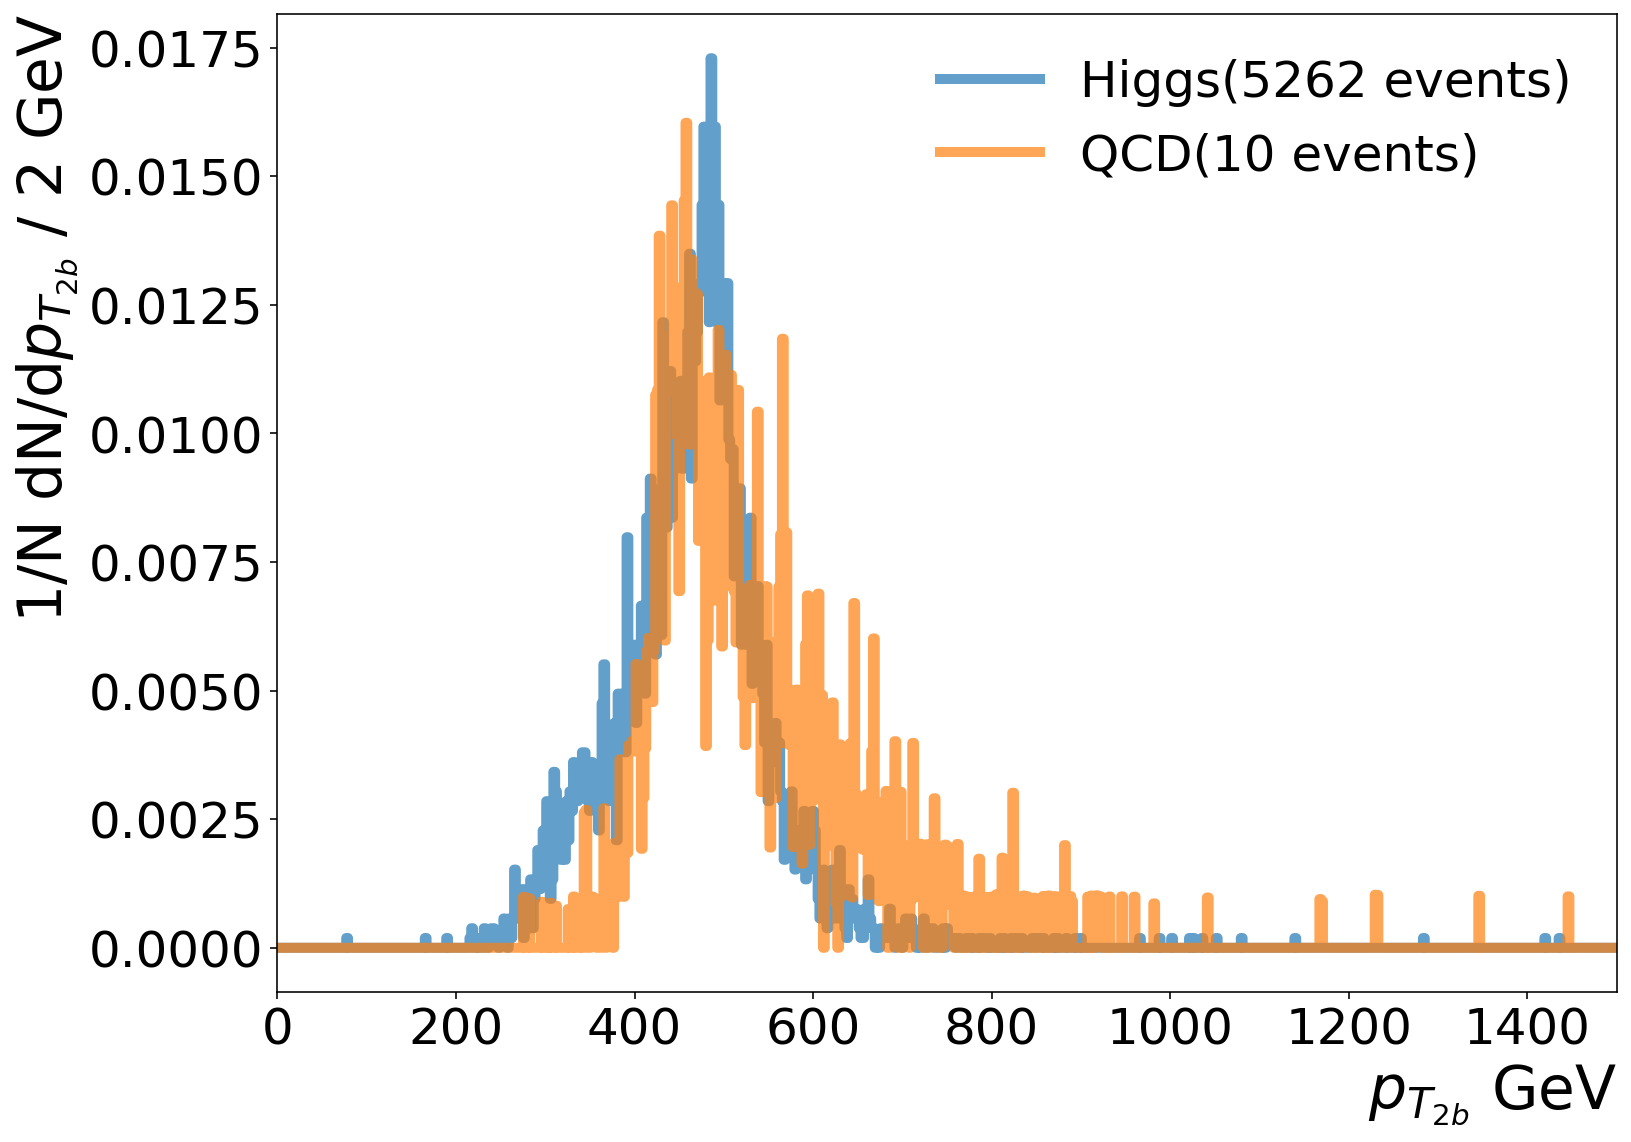

CPU times: user 616 ms, sys: 36.2 ms, total: 652 ms
Wall time: 651 ms


In [72]:
%%time

fig, ax = plt.subplots(1,1, figsize=(12,9))
length = np.linspace(0,2000,1001)

index = 0

hist, bins = np.histogram(PT_h[index], bins=length, weights=weight[index])
plt.step(bins[:-1], 
         hist.astype(np.float32) / hist.sum() ,
#          hist.astype(np.float32) ,
         where='mid',
         linewidth=5, 
         alpha=0.7,
         label="Higgs({} events)".format(len(PT_h[0])))

index = 2

hist, bins = np.histogram(PT_h[index], bins=length, weights=weight[index])
plt.step(bins[:-1], 
         hist.astype(np.float32) / hist.sum() ,
#          hist.astype(np.float32) ,
         where='mid',
         linewidth=5, 
         alpha=0.7,
         label="QCD({} events)".format(len(PT_h[1])))

ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
plt.xlim((0,1500))
plt.xlabel("$p_{T_{2b}}$ GeV", fontsize=30,horizontalalignment='right',x=1) 

plt.legend(loc="upper right",ncol=1,fontsize=25, edgecolor = "w",fancybox=False, framealpha=0)
    
# plt.ylim((0., 0.18))
plt.ylabel("1/N dN/d$p_{T_{2b}}$ / 2 GeV", fontsize=30, horizontalalignment='right',y=1)
plt.show() 

<a id="jet_trimming"></a>
# Step 11: Jet Trimmimng

[Back to the top](#TOP)

In [73]:
process_list_clustered_trimmed = []
# for i in range(len(Higgs_candidate)):
for i in range(len(process_list_clustered)):
    process_list_clustered_trimmed.append([])

#
# for N, process in enumerate(Higgs_candidate_4b):
for N, process in enumerate(process_list_clustered):
#     print(time.strftime("%a %b %d %H:%M:%S %Y", time.localtime()))
    ticks_1 = time.time()
    
    for jets in tqdm(process):
        jet_trimmed_list = []
#         if len(jets) < 2:
#             continue
        for jet_untrimmed in jets:
            jet_trimmed = jet_trim(jet_untrimmed)[0]
            jet_trimmed_list.append(jet_trimmed)
        
        process_list_clustered_trimmed[N].append(jet_trimmed_list)
        
    ticks_2 = time.time()
    totaltime =  ticks_2 - ticks_1
    print("\033[3;33mTime Cost : {:.4f} min\033[0;m".format(totaltime/60.))
    
    time.sleep(1)

100%|██████████| 10000/10000 [00:10<00:00, 909.22it/s]


Time Cost : 0.1834 min


100%|██████████| 10000/10000 [00:11<00:00, 901.20it/s]


Time Cost : 0.1850 min


100%|██████████| 10000/10000 [00:11<00:00, 844.56it/s]


Time Cost : 0.1974 min


100%|██████████| 10000/10000 [00:11<00:00, 857.18it/s]


Time Cost : 0.1945 min


<a id="events_selection"></a>
# Step 12: di-Jet Events' Selection From Truth Record



[Back to the top](#TOP)

In [3]:
HOMEPATH = "./"
Data_High_Level_Features_path =  "./"

process = {
            "ppHhh" : 0,
            "ttbar" : 0,
            "ppbbbb" : 0,
            "ppjjjj" : 0,
              }  


try:
    
    for element in tqdm(process):
        process[element] = pd.read_csv(Data_High_Level_Features_path + str(element) + ".csv")

        print("{}'s event number: {}".format(element,len(process[element])))
        
    for i, element in enumerate(process):
        total_list = process[element].columns
        break
    
    print("total_list",total_list)

except:
    print("Error")

 25%|██▌       | 1/4 [00:01<00:03,  1.05s/it]

ppHhh's event number: 100000


 50%|█████     | 2/4 [00:01<00:01,  1.01it/s]

ttbar's event number: 98765


 75%|███████▌  | 3/4 [00:02<00:00,  1.03it/s]

ppbbbb's event number: 100000


100%|██████████| 4/4 [00:04<00:00,  1.04s/it]

ppjjjj's event number: 100000
total_list Index(['PRO', 'MJJ_0', 'delta_eta_0', 'XHH_0', 'MJ1_0', 'PTJ1_0', 'eta1_0',
       'phi1_0', 't211_0', 'D211_0', 'D221_0', 'C211_0', 'C221_0', 'MJ2_0',
       'PTJ2_0', 'eta2_0', 'phi2_0', 't212_0', 'D212_0', 'D222_0', 'C212_0',
       'C222_0', 'MJJ', 'delta_eta', 'XHH', 'MJ1', 'PTJ1', 'eta1', 'phi1',
       't211', 'D211', 'D221', 'C211', 'C221', 'MJ2', 'PTJ2', 'eta2', 'phi2',
       't212', 'D212', 'D222', 'C212', 'C222', 'four_b_tag', 'three_b_tag',
       'two_b_tag', 'weight', 'eventindex'],
      dtype='object')


In [24]:
%%time
def ET(pt, m):
    ET = np.sqrt(m**2 + pt**2)
    return  ET

preselection = {
                "Trigger" : np.zeros(len(process)),
                "PT_J1" : np.zeros(len(process)),
                "PT_J2" : np.zeros(len(process)),
                "Eta" : np.zeros(len(process)),
                "M_J" : np.zeros(len(process)),
                "Delta_Eta" : np.zeros(len(process)),
                "MJJ" : np.zeros(len(process)),
                "XHH" : np.zeros(len(process)),
                "four_b_tag" : np.zeros(len(process)),
                "three_b_tag" : np.zeros(len(process)),
                "two_b_tag" : np.zeros(len(process)),
              }


process_selected = {
                    "ppHhh" : 0,
                    "ttbar" : 0,
                    "ppbbbb" : 0,
                    "ppjjjj" : 0,
              }  

"""
Mass Cut and PT cut
"""
#######################
for j , element in enumerate(process):
    tmp = process[element]
    tmp["ET_0"] = ET(tmp["PTJ1_0"], tmp["MJ1_0"])
    
    """
    Trigger
    """
    tmp = tmp[(tmp["ET_0"] > 420) & (tmp["MJ1_0"] > 35)]
    preselection["Trigger"][j] = len(tmp)/len(process[element])
    
    """
    PT(J1) > 450 GeV 
    """
    
    tmp = tmp[(tmp["PTJ1_0"] > 450)]
    preselection["PT_J1"][j] = len(tmp)/len(process[element])
    
    """
    PT(J2) > 250 GeV 
    """
    
    tmp = tmp[(tmp["PTJ2_0"] > 250)]
    preselection["PT_J2"][j] = len(tmp)/len(process[element])
    
    """
    |Eta(J1)| < 2 & |Eta(J2)| < 2 
    """
    
    tmp = tmp[(abs(tmp["eta1_0"]) < 2) & (abs(tmp["eta2_0"]) < 2)]
    preselection["Eta"][j] = len(tmp)/len(process[element])
    
    """
    M(J1) > 50 GeV &  M(J2) > 50 GeV
    """
    
    tmp = tmp[(tmp["MJ1_0"] > 50) & (tmp["MJ2_0"] > 50)]
    preselection["M_J"][j] = len(tmp)/len(process[element])
    
    """
    |Delta[Eta(J1),Eta(J2)]| < 1.3
    """
    
    tmp = tmp[(abs(tmp["delta_eta_0"]) < 1.3)]
    preselection["Delta_Eta"][j] = len(tmp)/len(process[element])
    
    """
    M(J1,J2) > 700 GeV
    """
    
    tmp = tmp[(tmp["MJJ_0"] > 700)]
    preselection["MJJ"][j] = len(tmp)/len(process[element])
    
    """
    X(H,H) < 5
    """
    
    tmp = tmp[(tmp["XHH_0"] < 10)]
    preselection["XHH"][j] = len(tmp)/len(process[element])
    
    
#     """
#     X(H,H) < 1.6
#     """
    
#     tmp = tmp[(tmp["XHH_0"] < 1.6)]
#     preselection["XHH"][j] = len(tmp)/len(process[element])

    """
    4b-tag 
    """
    
    tmp = tmp[(tmp["four_b_tag"] == 1)]
    preselection["four_b_tag"][j] = len(tmp)/len(process[element])
    
#     """
#     3b-tag 
#     """
    
#     tmp = tmp[(tmp["three_b_tag"] == 1)]
#     preselection["three_b_tag"][j] = len(tmp)/len(process[element])
    
#     """
#     2b-tag 
#     """
    
#     tmp = tmp[(tmp["two_b_tag"] == 1)]
#     preselection["two_b_tag"][j] = len(tmp)/len(process[element])
    
    process_selected[element] = tmp
#######################




logging.info("\r")       
logging.info("Preselection Efficiency")
logging.info("\r")


preselection_process = {"ppHhh":[],
                        "ttbar":[],
                        "ppbbbb":[],
                        "ppjjjj":[],
                       }

for element in preselection:
    tmp = preselection[element]
    
    
    for i, var in enumerate(preselection_process):
        preselection_process[var].append(np.round(tmp[i],5))

# print("\r")       
# print("Preselection Efficiency")
# print("\r")
# print("{:^10}{:^10}{:^10}{:^10}{:^10}".format("","ppHhh","ttbar","ppbbbb","ppjjjj"))


        
# print("\r")
# for element in preselection:
#     tmp = preselection[element]
# #     print("{:^10}{:^10.3f}{:^10.3f}{:^10.3f}{:^10.3f}".format(str(element),tmp[0],tmp[1],tmp[2],0))
#     print("{:^10}{:^10.3f}{:^10.3f}{:^10.3f}{:^10.3f}".format(str(element),tmp[0],tmp[1],tmp[2],tmp[3]))



preselection_process = pd.DataFrame(preselection_process,
            index=["Trigger","PT_J1","PT_J2","Eta","M_J","Delta_Eta","MJJ","XHH","four_b_tag","three_b_tag","two_b_tag"]
            )

preselection_process



INFO:root:
INFO:root:Preselection Efficiency
INFO:root:


CPU times: user 180 ms, sys: 2.74 ms, total: 182 ms
Wall time: 179 ms


,ppHhh,ttbar,ppbbbb,ppjjjj
Trigger,0.67359,0.05713,0.73345,0.80281
PT_J1,0.52303,0.03258,0.53447,0.60548
PT_J2,0.51873,0.03165,0.51631,0.59420
Eta,0.49846,0.02895,0.47769,0.50320
M_J,0.48797,0.02866,0.43234,0.48179
Delta_Eta,0.44337,0.02048,0.29808,0.28441
MJJ,0.44322,0.02047,0.29731,0.28386
XHH,0.22439,0.00090,0.03885,0.04889
four_b_tag,0.18825,0.00000,0.00716,0.00011
three_b_tag,0.00000,0.00000,0.00000,0.00000


In [25]:
def Z(eff_sig, eff_ttbar, eff_ppbbbb, eff_ppjjjj, lum):

    sig_ppHhh = eff_sig*0.00081186*0.85*0.36*1000*lum
    bkg_ttbar = eff_ttbar*1106.20050901*1000*lum
    bkg_ppbbbb = eff_ppbbbb*0.4069888956*1000*lum
    bkg_ppjjjj = eff_ppjjjj*11087.8358304*1000*lum
    
    z = sig_ppHhh/np.sqrt(bkg_ttbar+bkg_ppbbbb+bkg_ppjjjj*0)
    
    return z, sig_ppHhh, bkg_ppbbbb



index = "four_b_tag"
z, sig_ppHhh, bkg_ppbbbb = Z(preselection_process["ppHhh"][index], 
                                             preselection_process["ttbar"][index], 
                                             preselection_process["ppbbbb"][index], 
                                             preselection_process["ppjjjj"][index], 
                                             139)


logging.info("\r")
logging.info("Signal Efficiency: {:.3f}".format(preselection_process["ppHhh"][index]))
logging.info("# of signal: {:.2f}".format(sig_ppHhh))
logging.info("# of bkg bbbb: {:.2f}".format(bkg_ppbbbb))
logging.info("\r")
logging.info("Significance: {:.3f}".format(z))
    
logging.info("\r")

INFO:root:
INFO:root:Signal Efficiency: 0.188
INFO:root:# of signal: 6.50
INFO:root:# of bkg bbbb: 405.05
INFO:root:
INFO:root:Significance: 0.323
INFO:root:


# Fitting Procedure

* Heavy–quark Yukawa couplings to the light (heavy) CP–even Higgs bosons for type II 2HDM.

Correction            |           Type II             | 
----------------------|:-----------------------------:|
1+ $\Delta^{h^0}_t$   | $\frac{\cos\alpha}{\sin\beta}$  |  
1+ $\Delta^{h^0}_b$   | $-\frac{\sin\alpha}{\cos\beta}$ |  
1+ $\Delta^{H^0}_t$   | $\frac{\sin\alpha}{\sin\beta}$  |  
1+ $\Delta^{H^0}_b$   | $\frac{\cos\alpha}{\cos\beta}$  |  

* Triple Higgs interactions involving the neutral CP–even Higgs fields in the 2HDM.

$$\lambda_{h^0h^0H^0} = \frac{\cos(\beta-\alpha)}{\sin2\beta}\left[\sin2\alpha(2m^2_{h^0}+m^2_{H^0})-\frac{2M_{12}^2}{\sin2\beta}(3\sin2\alpha-\sin2\beta) \right]$$

* The cross section is propotional to amplitude square: 

$$\sigma \propto|\mathcal{A}(pp\to H \to hh \to b\bar{b}b\bar{b})|^2 \propto $$

$$\left|\left[ (1+ \Delta^{H^0}_t)\times\lambda_{h^0h^0H^0}\times(1+ \Delta^{h^0}_b)^2 \right] + \left[(1+ \Delta^{H^0}_b)\times\lambda_{h^0h^0H^0}\times(1+ \Delta^{h^0}_b)^2\right] \right|^2 =$$

$$\left| \left[ (1+ \Delta^{H^0}_t)+(1+ \Delta^{H^0}_b)\right]\times\lambda_{h^0h^0H^0}\times(1+ \Delta^{h^0}_b)^2  \right|^2$$

* The relation between upper limit for number of signal and  number of survival Monte Carlo signal samples at benchmark point can be written in

$$\frac{N^{sig}_{\text{limit}}}{N^{sig}_{\text{MC}}}= \frac{|\mathcal{A}(pp\to H \to hh \to b\bar{b}b\bar{b})|^2(\cos(\beta-\alpha),M_{12}^2)}{|\mathcal{A}(pp\to H \to hh \to b\bar{b}b\bar{b})|^2_{\tan\beta=5,M_{12}^2=400000,\cos(\beta-\alpha)=0.08}}$$


* Our benchmark point is at $\tan\beta$=5, $M_{12}^2$=400000$\text{GeV}^2$, $\cos(\beta-\alpha)$=0.08, $M_H=M_A=M_{H^{\pm}}$=1000GeV, $M_h$=125GeV. 
> At this benchmark point, we the $H\to h h $ is dominant decay mode. ($Br(H\to h h)\approx $0.85)


* $N^{sig}_{\text{limit}}$ is the function of $\cos(\beta-\alpha)$ and $M_{12}^2$.

$$N^{sig}_{\text{limit}}= \frac{|\mathcal{A}(pp\to H \to hh \to b\bar{b}b\bar{b})|^2(\cos(\beta-\alpha),M_{12}^2)}{|\mathcal{A}(pp\to H \to hh \to b\bar{b}b\bar{b})|^2_{\tan\theta=5,M_{12}^2=400000,\cos(\beta-\alpha)=0.08}}\times N^{sig}_{\text{MC}}$$

* $N^{sig}_{\text{MC}}$, $N^{bkg}_{\text{MC}}$ can be obtained after we apply ML classifier.


* Treat $N^{sig}_{\text{MC}}$, $N^{bkg}_{\text{MC}}$ as 1 bin case and use CLs method to get expected signal strengths in $2\sigma$ and $1\sigma$ bands at 95%C.L.

* Translate expected signal strengths to be number of signal events in $2\sigma$ and $1\sigma$ bands at 95%C.L.
$$1\sigma\,\, \text{band} = [s_{-1\sigma}\times N^{sig}_{\text{MC}},s_{1\sigma}\times N^{sig}_{\text{MC}}]$$
$$2\sigma\,\, \text{band} = [s_{-2\sigma}\times N^{sig}_{\text{MC}},s_{2\sigma}\times N^{sig}_{\text{MC}}]$$

* After scan $\cos(\beta-\alpha)$ and $M_{12}^2$, we can pick allowed sets which let $N^{sig}_{\text{limit}}$ in the $1\sigma\,\, \text{band}$ or $2\sigma\,\, \text{band}$ regions.


Ref: [Higgs pair production via gluon fusion in the Two-Higgs-Doublet Model](https://arxiv.org/abs/1407.0281)  
Ref: [Exploring sizable triple Higgs couplings in the 2HDM](https://arxiv.org/abs/2005.10576)  
Ref: [LHC Search of New Higgs Boson via Resonant Di-Higgs Production with Decays into 4W](https://arxiv.org/abs/1706.05980)

In [91]:
"""
Convertion:
0 ≤ \beta - \alpha ≤ 𝜋


0 < \beta <  𝜋/2
"""


"""
lambda_Hhh(cb_a, m12s, tb, mH, mh=125 )
"""

def lambda_Hhh(cb_a, m12s, tb, mH, mh=125 ):
    b_a = np.arccos(cb_a)
    b = np.arctan(tb)
    a = np.arctan(tb) - np.arccos(cb_a)
    
    ########################################################################
    """
    arXiv:2005.10576v2 Eq. (32)
    """
    
    part_a = (2*mh**2+mH**2-4*(m12s/(np.sin(b)*np.cos(b))))*np.sin(b_a)**2
    part_b = 2*1/np.tan(2*b)*(2*mh**2+mH**2-3*(m12s/(np.sin(b)*np.cos(b))))*np.sin(b_a)*cb_a
    part_c = (2*mh**2+mH**2-2*(m12s/(np.sin(b)*np.cos(b))))*cb_a**2

    return -1*cb_a/246*(part_a+part_b-part_c)
    ########################################################################
    
    
    
"""
gHt(cb_a, tb)
"""
def gHt(cb_a, tb):
    b_a = np.arccos(cb_a)
    b = np.arctan(tb)
    a = np.arctan(tb) - np.arccos(cb_a)
    
    return np.sin(a)/np.sin(b)

    
"""
gHb(cb_a, tb)
"""
def gHb(cb_a, tb):
    b_a = np.arccos(cb_a)
    b = np.arctan(tb)
    a = np.arctan(tb) - np.arccos(cb_a)
    
    return np.cos(a)/np.cos(b)
    

"""
ght(cb_a, tb)
"""
def ght(cb_a, tb):
    b_a = np.arccos(cb_a)
    b = np.arctan(tb)
    a = np.arctan(tb) - np.arccos(cb_a)
    
    return np.cos(a)/np.sin(b)

    
"""
ghb(cb_a, tb)
"""
def ghb(cb_a, tb):
    b_a = np.arccos(cb_a)
    b = np.arctan(tb)
    a = np.arctan(tb) - np.arccos(cb_a)
    
    return -1*np.sin(a)/np.cos(b)
    
    
    
"""
Constraint(cb_a, m12s, tb, mH, mh=125, luminosity = 3000, acceptance = 0.5, Xection = 0.01)

luminosity (fb^-1)
Xection (pd)

m_h:    125.00000
m_H:   1000.00000
m_A:   1001.00000
m_H+:   1001.00000
sin(b-a):      0.99612
lambda_6:      0.00000
lambda_7:      0.00000
m12^2: 400000.00000
tan(beta):      5.00000  (fix)


np.arctan(5) - 𝜋  ≤ \alpha ≤  np.arctan(5)

"""    
    
def Constraint_N(cb_a, m12s, tb, mH, mh=125, luminosity = 3000, acceptance = 0.5, Xection = 0.01):
    
    N_MC = luminosity*acceptance*(Xection*1000)
    
    numerator = ((1+gHt(cb_a, tb)) + (1+gHb(cb_a, tb)))**2 * (lambda_Hhh(cb_a, m12s, tb, mH, mh=125 )**2) * (1+ghb(cb_a, tb))**4
    
    cba = np.cos(np.arcsin(0.99612))
    denominator =  ((1+gHt(cba, 5)) + (1+gHb(cba, 5)))**2 * (lambda_Hhh(cba, 400000, 5, 1000, mh=125 )**2) * (1+ghb(cba, 5))**4
    
    return N_MC*(numerator/denominator) #




"""
Statistics
"""

def chi_square(n_s, n_b):
    
    #[(s+b - b) / sqrt(b)]^2
    
    chisquare = (n_s)**2/n_b
    
    return chisquare

def tmu_pyhf(nH, n_QCD):

    model = pyhf.simplemodels.hepdata_like(
        signal_data=[nH], bkg_data=[n_QCD], bkg_uncerts=[np.sqrt(n_QCD)]

    )

    test_mu = 1.0
    init_pars = model.config.suggested_init()
    par_bounds = model.config.suggested_bounds()
    par_bounds[model.config.poi_index] = [-10.0, 10.0]
    fixed_params = model.config.suggested_fixed()
    
    return pyhf.infer.test_statistics.tmu(test_mu, observations, model, init_pars, par_bounds, fixed_params)


def qmu_tilde_pyhf(nH, n_QCD):

    model = pyhf.simplemodels.hepdata_like(
        signal_data=[nH], bkg_data=[n_QCD], bkg_uncerts=[np.sqrt(n_QCD)]

    )

    test_mu = 1.0
    init_pars = model.config.suggested_init()
    par_bounds = model.config.suggested_bounds()
    fixed_params = model.config.suggested_fixed()
    
    return pyhf.infer.test_statistics.qmu_tilde(test_mu, observations, model, init_pars, par_bounds, fixed_params)





In [92]:
%%time
time.sleep(1)
start = time.time()

"""
ppbbbb
"""
# Herwig
# 0.425     0.253    
# H: 0.372 QCD: 0.013129 

# default
# 0.426     0.275 
# H: 0.354 QCD: 0.017518
     
# vincia
# 0.421     0.214    
# H: 0.368 QCD: 0.011385 

# dipole
# 0.417     0.206  
# H: 0.371 QCD: 0.018809 

                

"""
ppjjjj
"""


dictionary = {
              "sig_Xection" : 0.00081305,
              "sig_Branching_ratio" : 0.8*0.6*0.6,
              "sig_acceptance": 0.354*0.426,
              "bkg_Xection" : 0.27741793,  # ppbbbb
              "bkg_acceptance" : 0.017518*0.275,
#               "bkg_Xection" : 7699.04176498,  # ppjjjj
#               "sig_acceptance" : 0.427*0.357,
#               "bkg_acceptance" : 0.274*0.000074 ,
              "luminosity": 3000
              }
    
#         sig_ppHhh = eff_sig*0.00081186*0.85*0.36*1000*lum
#     bkg_ttbar = eff_ttbar*1106.20050901*1000*lum
#     bkg_ppbbbb = eff_ppbbbb*0.4069888956*1000*lum
#     bkg_ppjjjj = eff_ppjjjj*11087.8358304*1000*lum
    
    
    
    
n_H = dictionary["sig_Xection"]*dictionary["sig_Branching_ratio"]*dictionary["sig_acceptance"]*dictionary["luminosity"]*1000  
n_QCD = dictionary["bkg_Xection"]*dictionary["bkg_acceptance"]*dictionary["luminosity"]*1000

print("# of H survival: {}".format(n_H))
print("# of QCD survival: {}".format(n_QCD))
print("Z= ", n_H/np.sqrt(n_QCD))
time.sleep(1)

n_slice = 5000
cb_a = np.linspace(-1 , 1,  n_slice)
m12_s = np.linspace(1E+5, 1E+6,  n_slice)


"""
Old
"""
##################
# cba = []
# m12s = []

# for element in tqdm(cb_a):
#     for j in range(len(m12_s)):
#         cba.append(element)
#         m12s.append(m12_s[j])

# cba = np.array(cba)
# m12s = np.array(m12s)   
# tb = np.full(n_slice*n_slice, 5)
# mH = np.full(n_slice*n_slice, 1000)
# mh = np.full(n_slice*n_slice, 125)
# luminosity = np.full(n_slice*n_slice, dictionary["luminosity"])
# acceptance = np.full(n_slice*n_slice, dictionary["sig_acceptance"])
# Xection = np.full(n_slice*n_slice, dictionary["sig_Xection"]*dictionary["sig_Branching_ratio"])

# # constraint_n = np.vectorize(Constraint_N)(cba, m12s, tb, mH, mh, luminosity, acceptance, Xection)
# constraint_n = Constraint_N(cba, m12s, tb, mH, mh, luminosity, acceptance, Xection)
# # print(constraint_n)
##################



cba, m12s = np.meshgrid(cb_a, m12_s)
tb = np.full((n_slice, n_slice), 5)
mH = np.full((n_slice, n_slice), 1000)
mh = np.full((n_slice, n_slice), 125)
luminosity = np.full((n_slice, n_slice), dictionary["luminosity"])
acceptance = np.full((n_slice, n_slice), dictionary["sig_acceptance"])
Xection = np.full((n_slice, n_slice), dictionary["sig_Xection"]*dictionary["sig_Branching_ratio"])

# constraint_n = np.vectorize(Constraint_N)(cba, m12s, tb, mH, mh, luminosity, acceptance, Xection)
constraint_n = Constraint_N(cba, m12s, tb, mH, mh, luminosity, acceptance, Xection)


finish = time.time()
print("Total TIme: {} min".format((finish-start)/60))



# of H survival: 105.93607006079998
# of QCD survival: 4009.3410206354997
Z=  1.6730439856432833
Total TIme: 0.27549355030059813 min
CPU times: user 9.48 s, sys: 6.03 s, total: 15.5 s
Wall time: 17.5 s


<a id="high_level_features"></a>
## Step 13: High Level Features

[Back to the top](#TOP)

In [5]:
class Samples:
    def __init__(self,\
                 ppHhh,\
                 ttbar,\
                 ppbbbb,\
                 ppjjjj,\
                 four_b_tag=False,\
                 three_b_tag=False,\
                 two_b_tag=False,\
                ):
        
        if four_b_tag == True:
            self.ppHhh = ppHhh[ppHhh["four_b_tag"]==1]
            self.ttbar = ttbar[ttbar["four_b_tag"]==1]
            self.ppbbbb = ppbbbb[ppbbbb["four_b_tag"]==1]
            self.ppjjjj = ppjjjj[ppjjjj["four_b_tag"]==1]
            
        elif three_b_tag == True:
            self.ppHhh = ppHhh[ppHhh["three_b_tag"]==1]
            self.ttbar = ttbar[ttbar["three_b_tag"]==1]
            self.ppbbbb = ppbbbb[ppbbbb["three_b_tag"]==1]
            self.ppjjjj = ppjjjj[ppjjjj["three_b_tag"]==1]
        
        elif two_b_tag == True:
            self.ppHhh = ppHhh[ppHhh["two_b_tag"]==1]
            self.ttbar = ttbar[ttbar["two_b_tag"]==1]
            self.ppbbbb = ppbbbb[ppbbbb["two_b_tag"]==1]
            self.ppjjjj = ppjjjj[ppjjjj["two_b_tag"]==1]
            
        else:
            self.ppHhh = ppHhh
            self.ttbar = ttbar
            self.ppbbbb = ppbbbb
            self.ppjjjj = ppjjjj
        
    def Signal_only(self,feature):
        H = [self.ppHhh[feature]]
        return H
    
    def Background_only(self,feature):
        QCD = [self.ttbar[feature],self.ppbbbb[feature] ,self.ppjjjj[feature]]
        return QCD
    
    def Signal_Background(self,feature):
        Both = [self.ppHhh[feature],self.ttbar[feature],self.ppbbbb[feature],self.ppjjjj[feature]]
        return Both
    

In [6]:
TotalSamples = Samples(process_selected["ppHhh"],
                       process_selected["ttbar"],
                       process_selected["ppbbbb"],
                       process_selected["ppjjjj"],
                       four_b_tag = 0,
                       three_b_tag = 0,
                       two_b_tag = 0,
                      )

In [7]:
def HIST(process, length, title, colors, linestyle,xpo=1,ypo=1):
    hist, bins = np.histogram(process, bins=length)
    plt.step(bins[:-1], hist.astype(np.float32) / hist.sum(), linestyle ,color= colors ,where='mid',linewidth=5, alpha=0.7, label=title[i])
#     plt.legend(bbox_to_anchor=(xpo, ypo),ncol=1,fontsize=30, edgecolor = "w",fancybox=False, framealpha=0)
    plt.legend(loc="best",ncol=1,fontsize=20, edgecolor = "w",fancybox=False, framealpha=0)


title = ["ppHhh","ttbar","ppbbbb","ppjjjj",
        ]
colors = ["green","red","blue","purple",
#           "cyan","black","Orange","lightblue"
         ]


linestyle = ["-","-.",":","--",
#              "--","o","v",":"
            ]


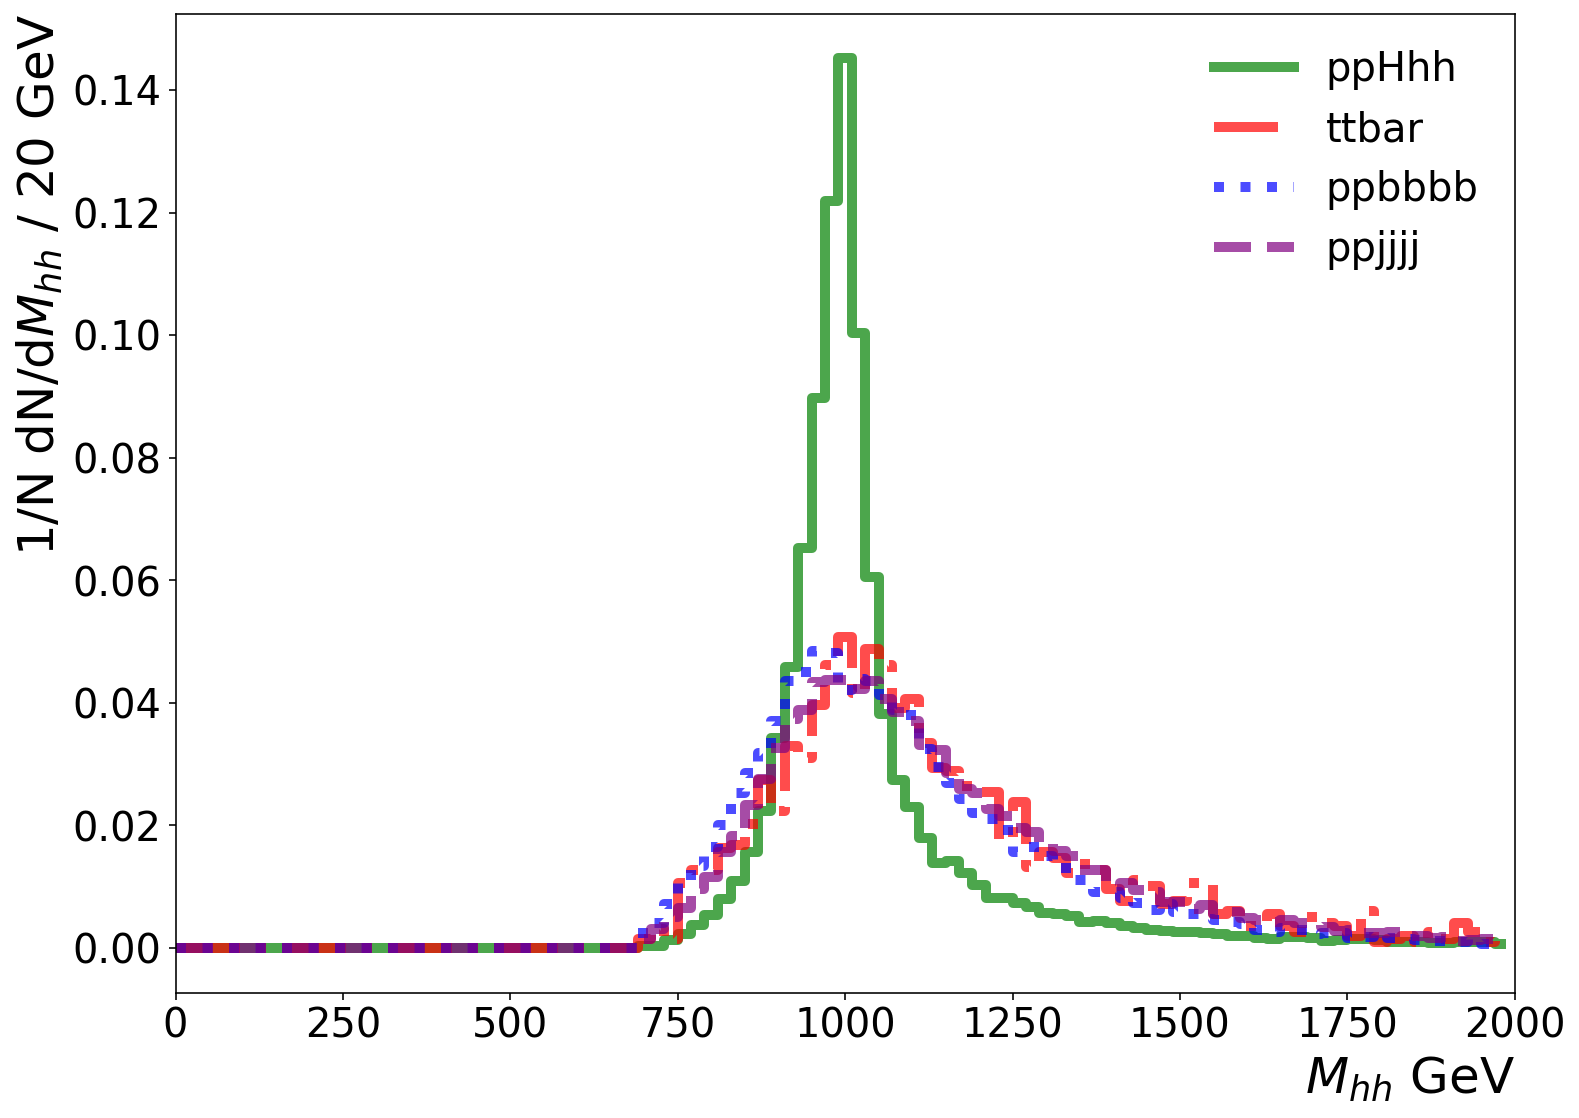

In [8]:
Mjj= TotalSamples.Signal_Background("MJJ_0")

fig, ax = plt.subplots(1,1, figsize=(12,9))
for i, element in enumerate(Mjj):
    length = np.linspace(0,2000,101)
    HIST(element, length, title,colors[i],linestyle[i])
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    plt.xlim((0,2000))
    plt.xlabel("$M_{hh}$ GeV", fontsize=25,horizontalalignment='right',x=1) 

    
# plt.ylim((0.))
# plt.yscale("log")
plt.ylabel("1/N dN/d$M_{hh}$ / 20 GeV", fontsize=25, horizontalalignment='right',y=1)
# plt.savefig("../Figures/m_hh_ihtmin_850.pdf", transparent=True, bbox_inches='tight')  #save figure as png
plt.show()   

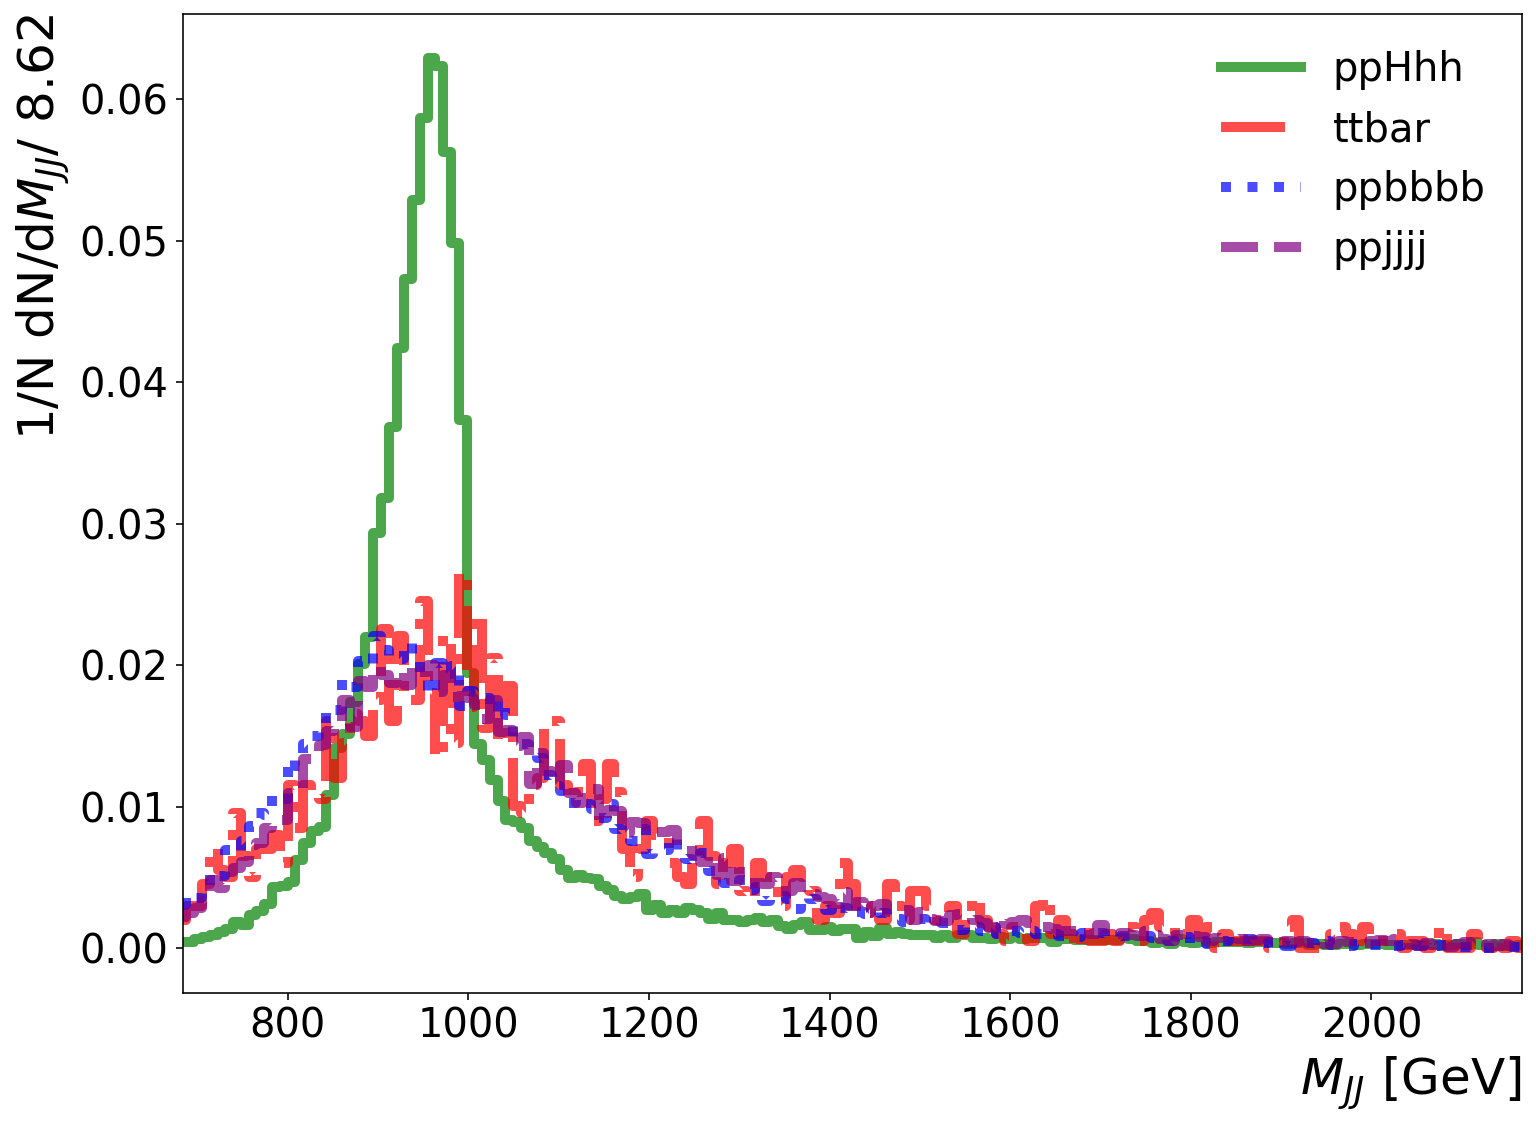

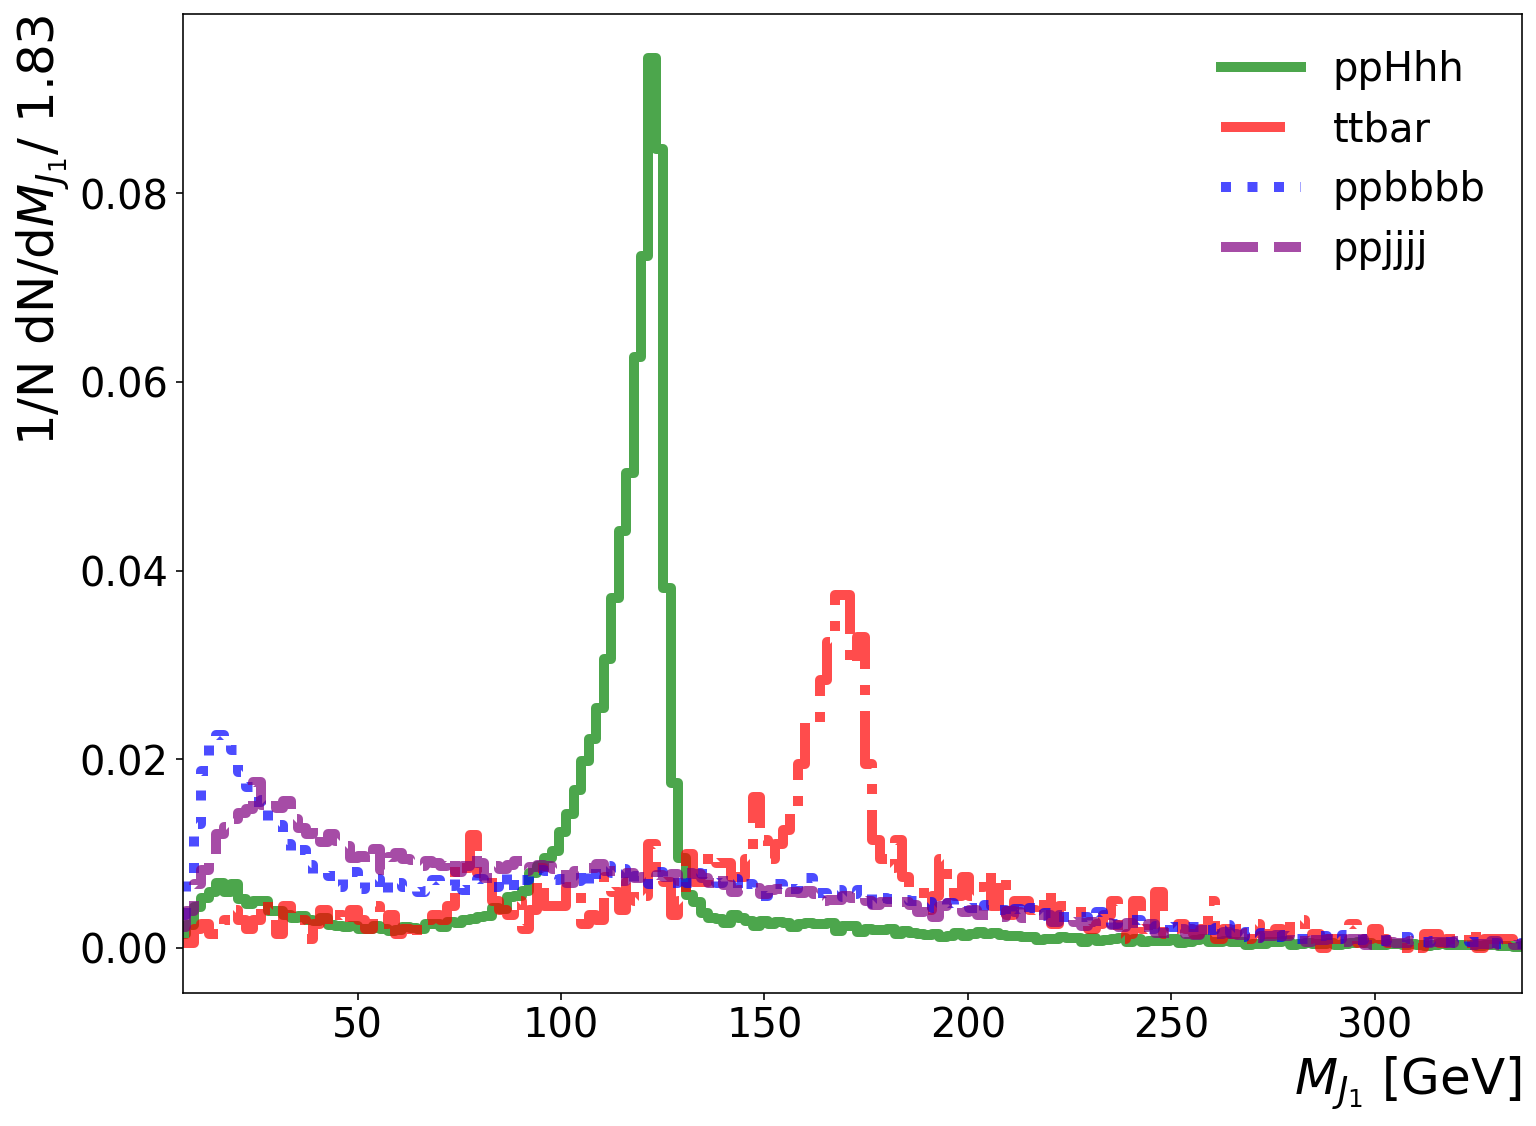

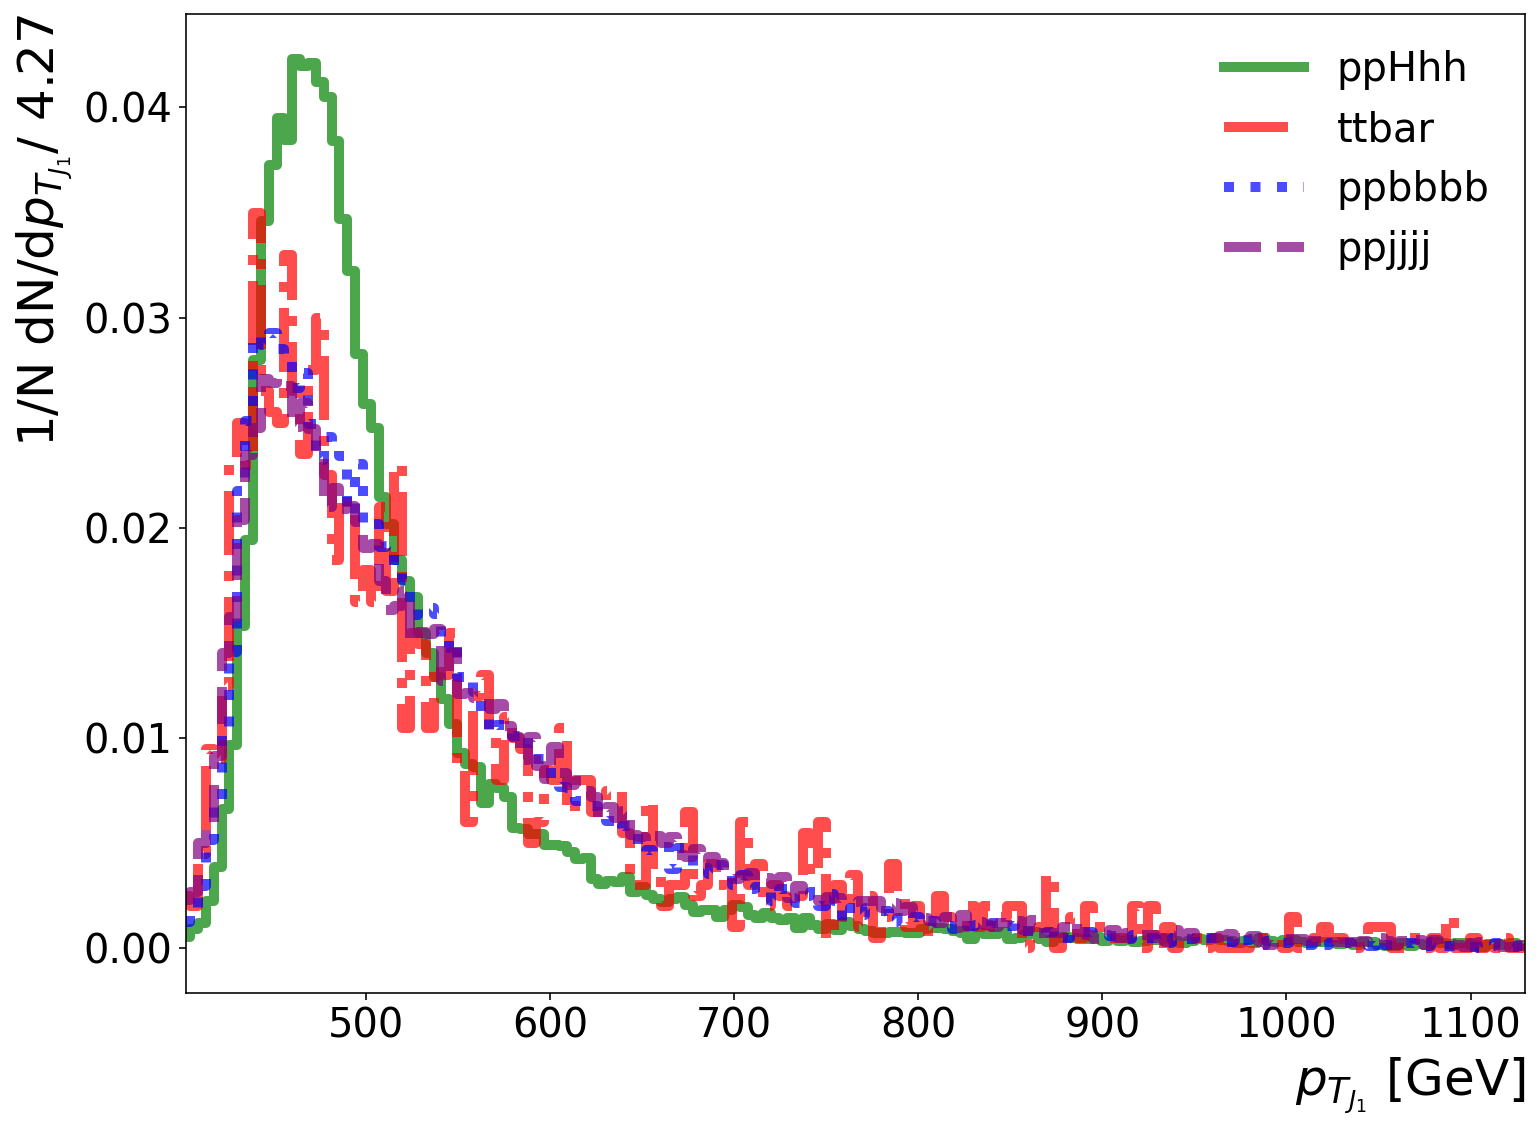

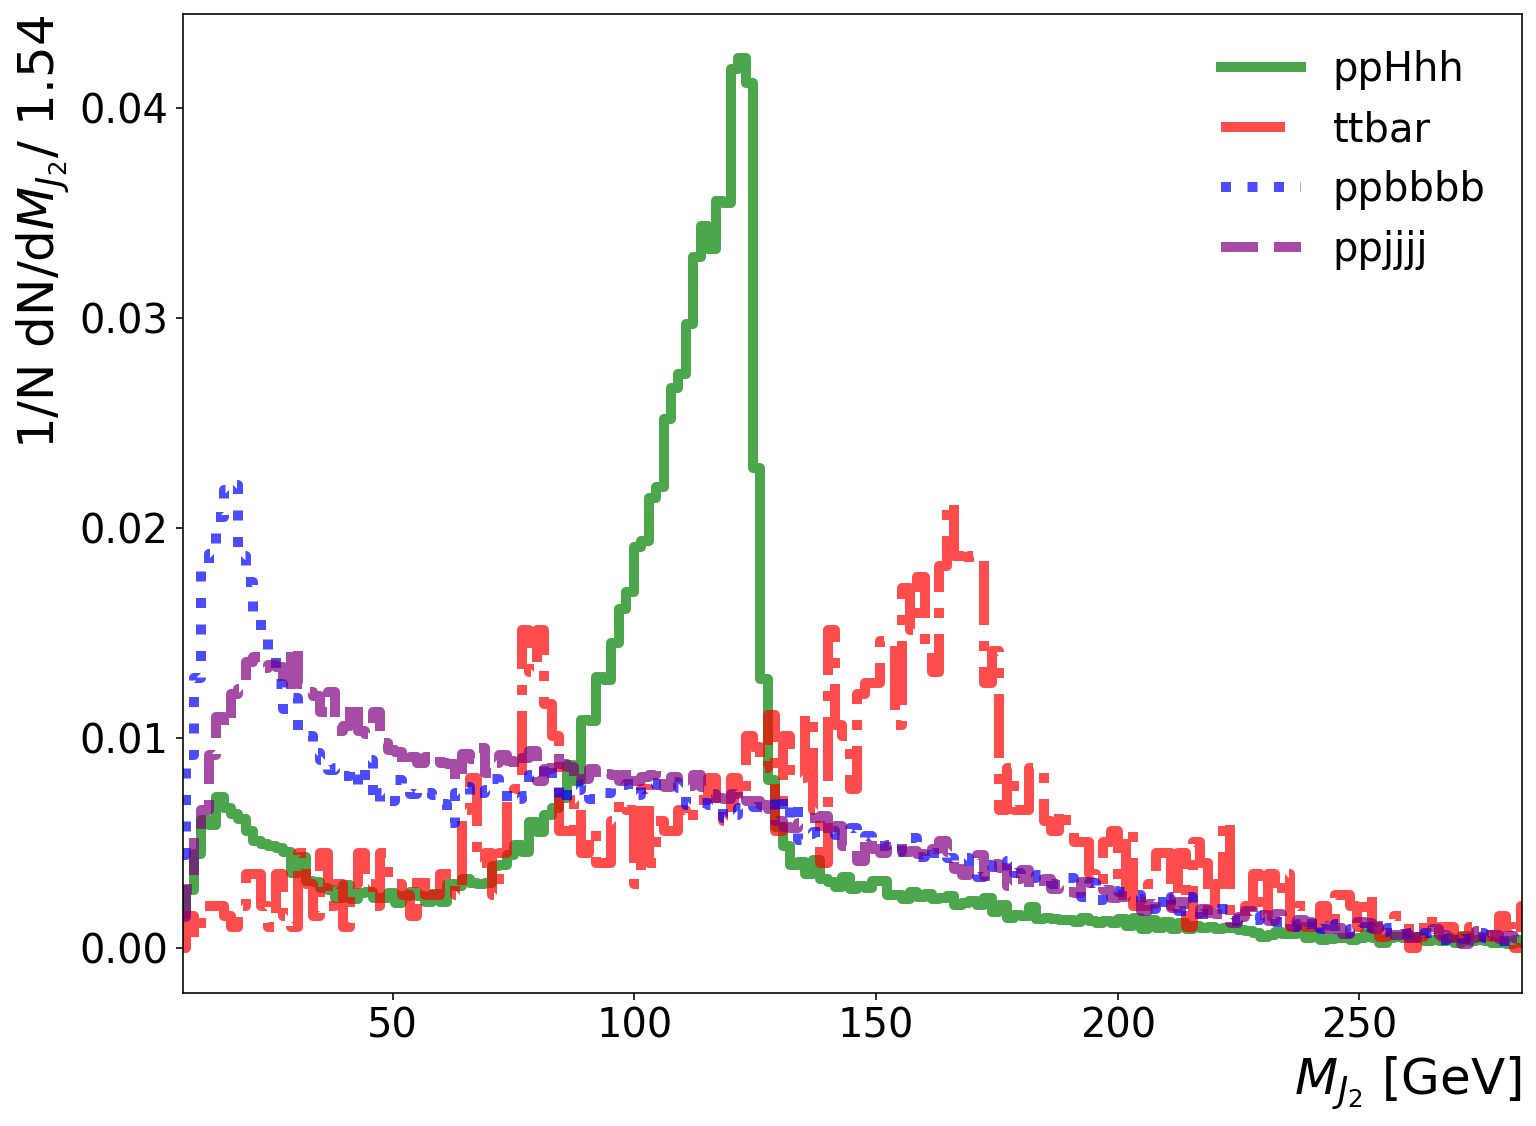

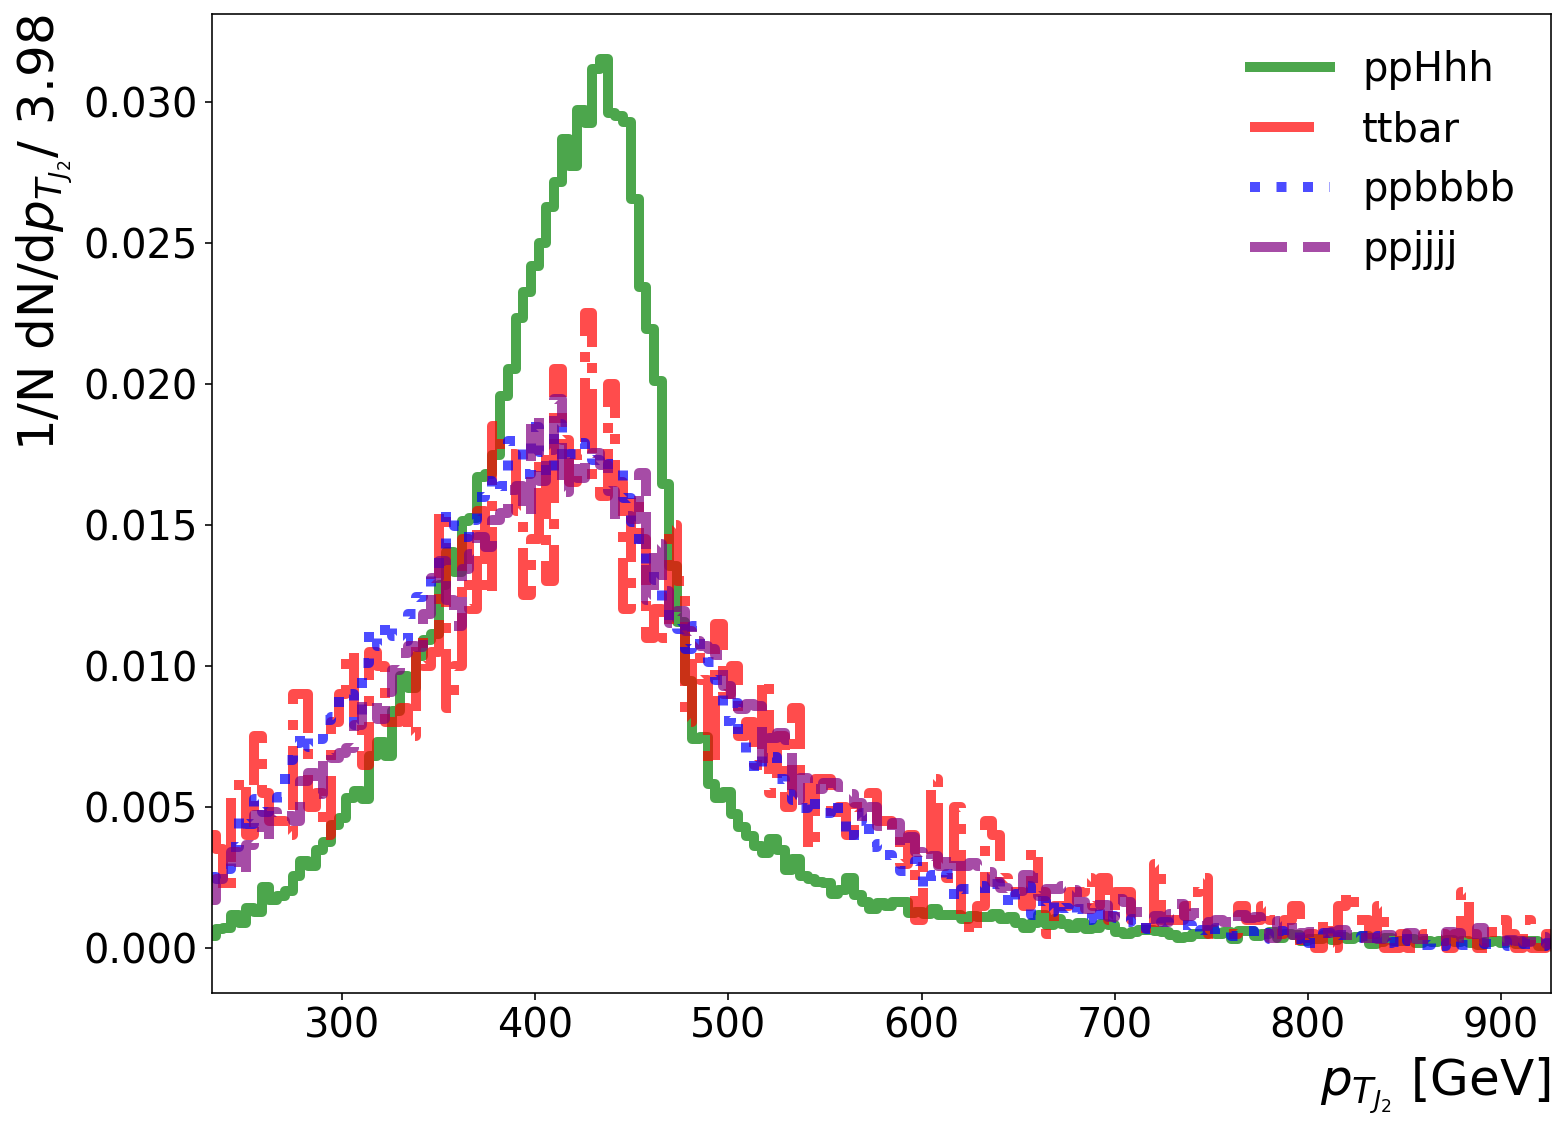

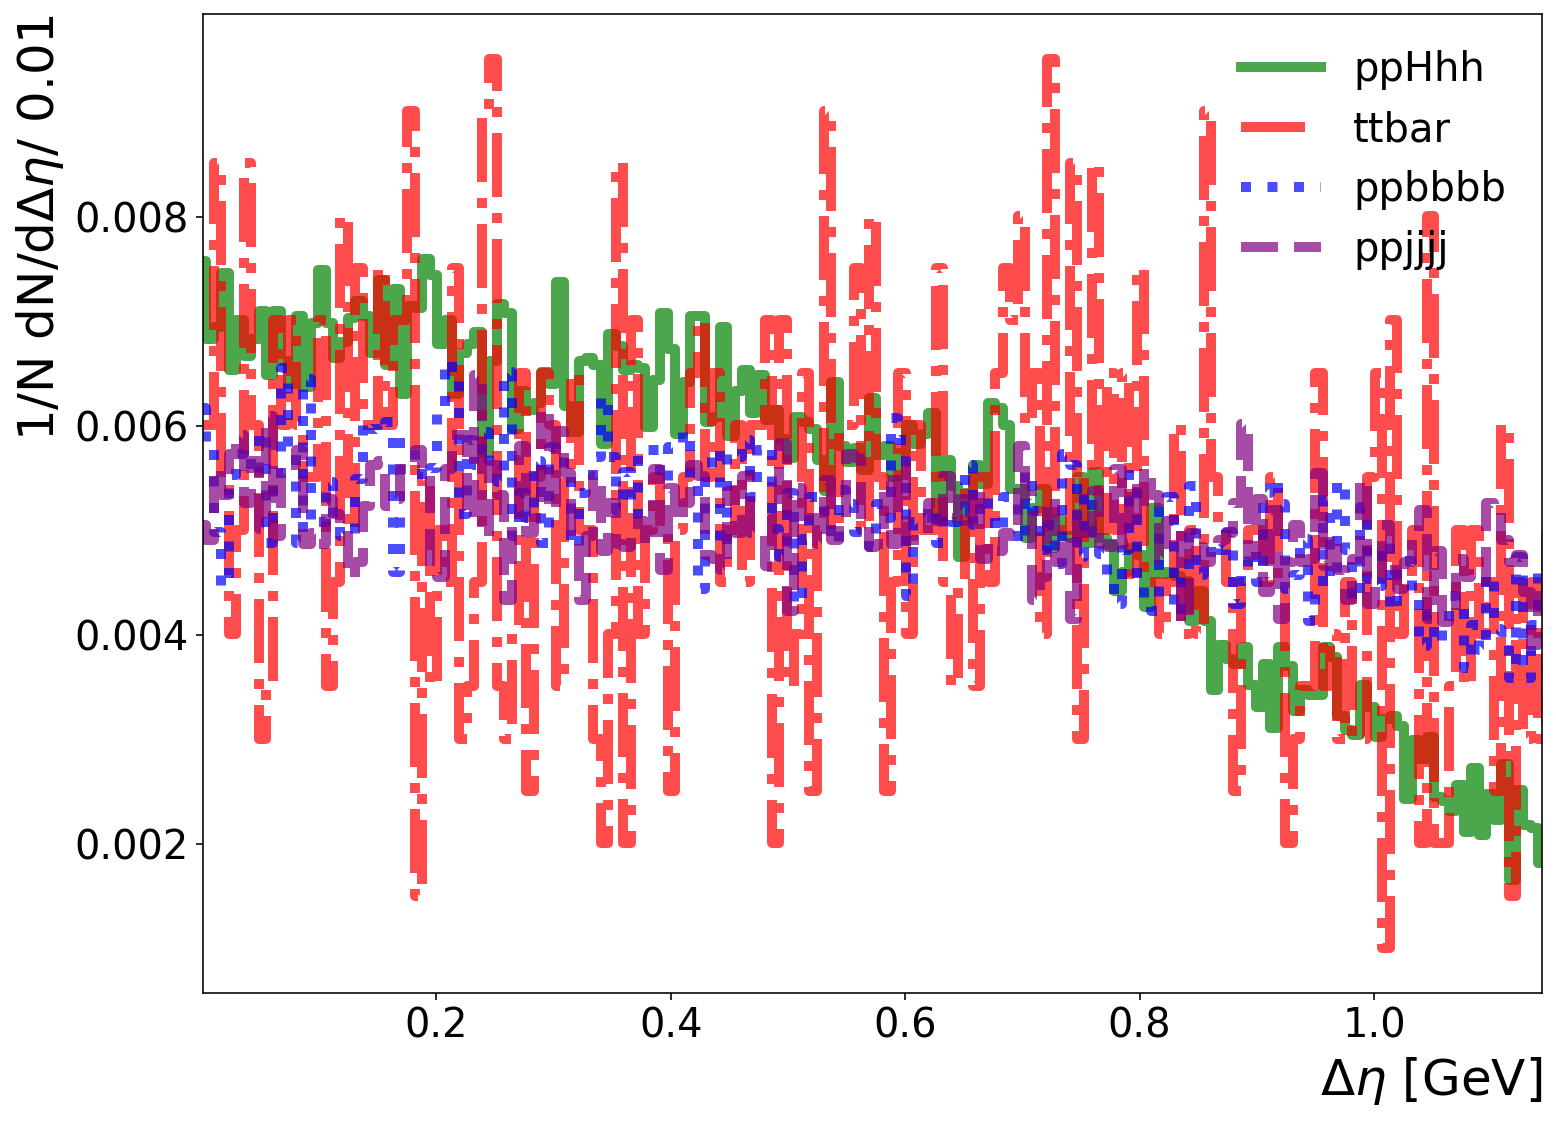

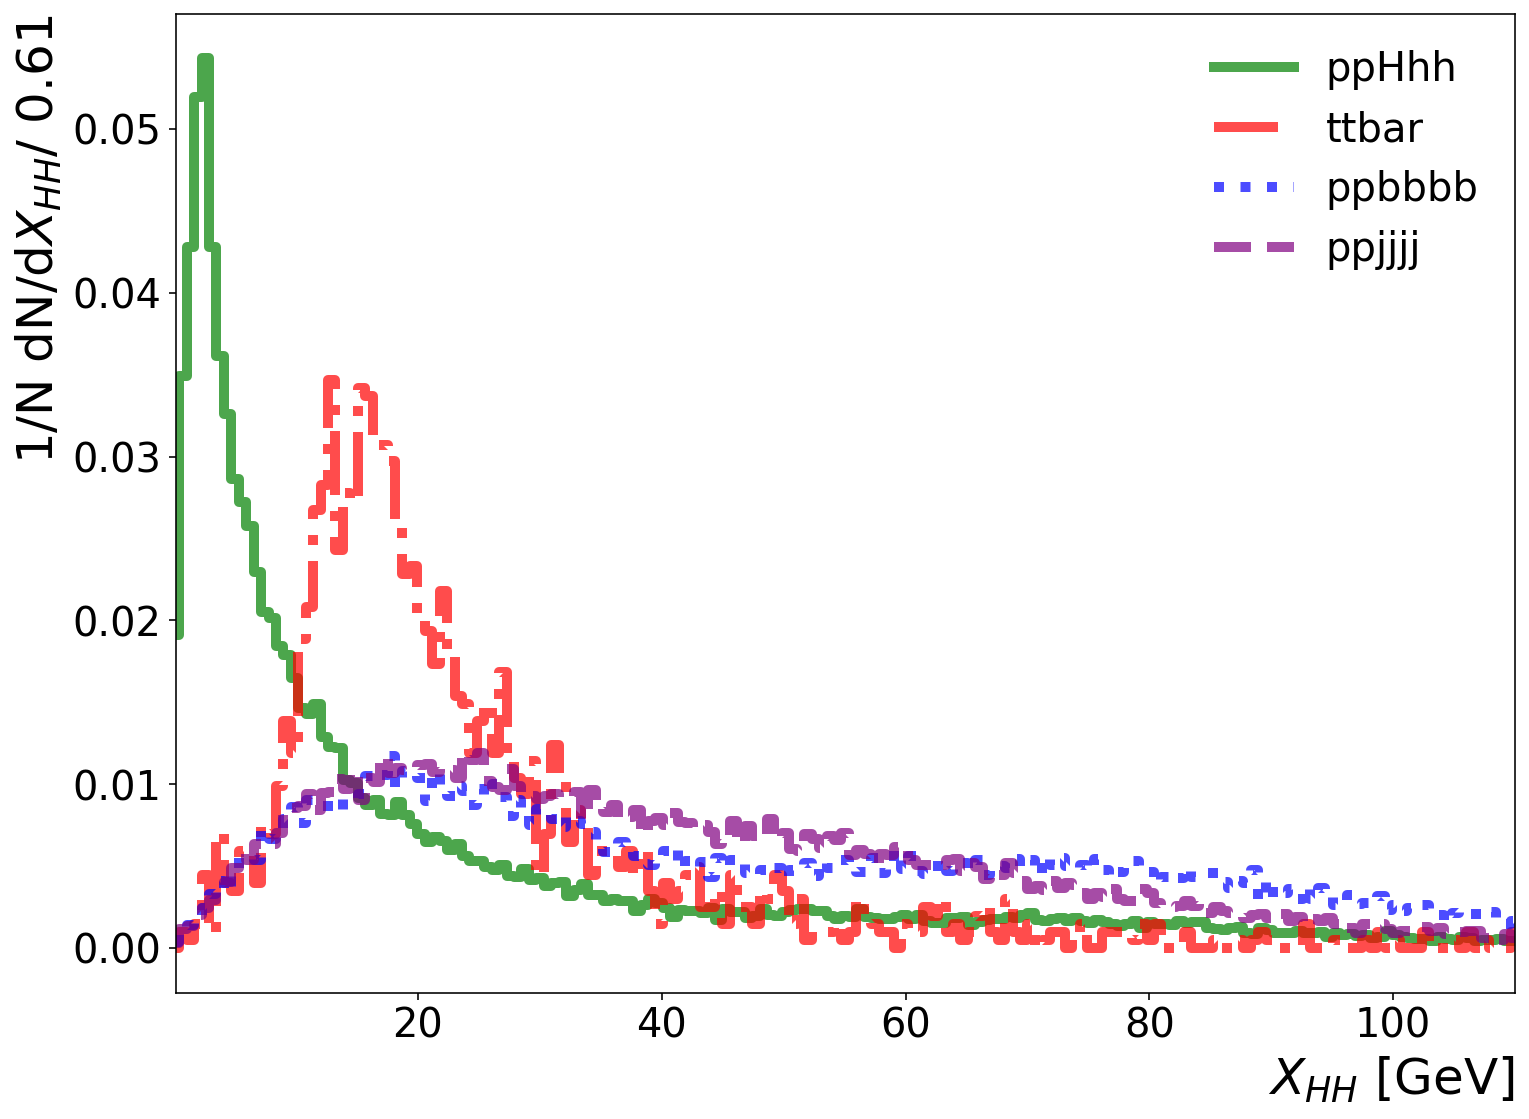

In [9]:
jet_kinematic = [
                  "MJJ","MJ1","PTJ1","MJ2","PTJ2",
                  "delta_eta", "XHH"
                ]
jet_kinematic_name = [
                       "$M_{JJ}$", "$M_{J_1}$", "$p_{T_{J_1}}$", "$M_{J_2}$", "$p_{T_{J_2}}$",
                       "$\Delta\eta$", "$X_{HH}$"
                     ]


for index, kinematic in enumerate(jet_kinematic):
    Kinematic= TotalSamples.Signal_Background(kinematic)


    fig, ax = plt.subplots(1,1, figsize=(12,9))
    for i, element in enumerate(Kinematic):

#         xmin, xmax = 0, np.max(process)
        xmin = np.sort(Kinematic[0])[int(len(Kinematic[0])*1/2000)] 
        xmax = np.sort(Kinematic[0])[int(len(Kinematic[0])*1990/2000)]
        length = np.linspace(xmin,xmax,201)
        HIST(element, length, title,colors[i],linestyle[i])
        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)
        plt.xlim((xmin,xmax*0.9))
        plt.xlabel(jet_kinematic_name[index]+" [GeV]", fontsize=25,horizontalalignment='right',x=1) 


    # plt.ylim((0.))
    unit = np.around((xmax-xmin)/200, decimals=2)
    
    plt.ylabel("1/N dN/d" +jet_kinematic_name[index]+ "/ "+str(unit) , fontsize=25, horizontalalignment='right',y=1)
    # plt.savefig("./Plots/m_ww_parton.png", transparent=True, bbox_inches='tight')  #save figure as png
    plt.show()  

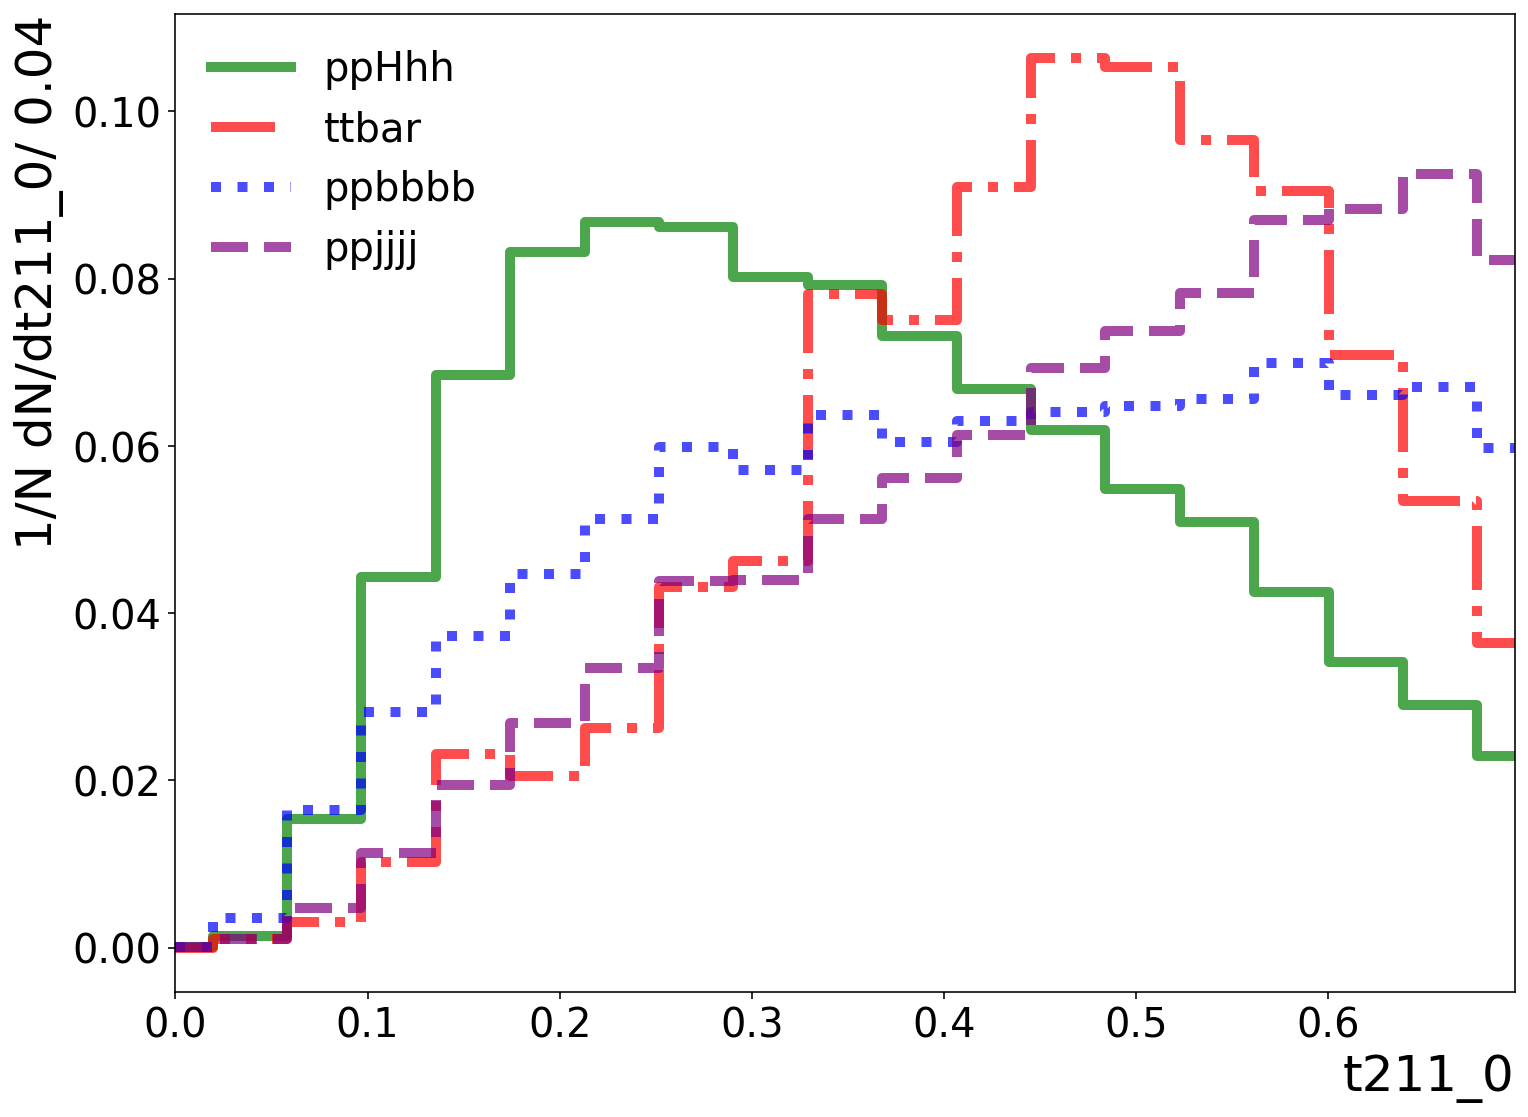

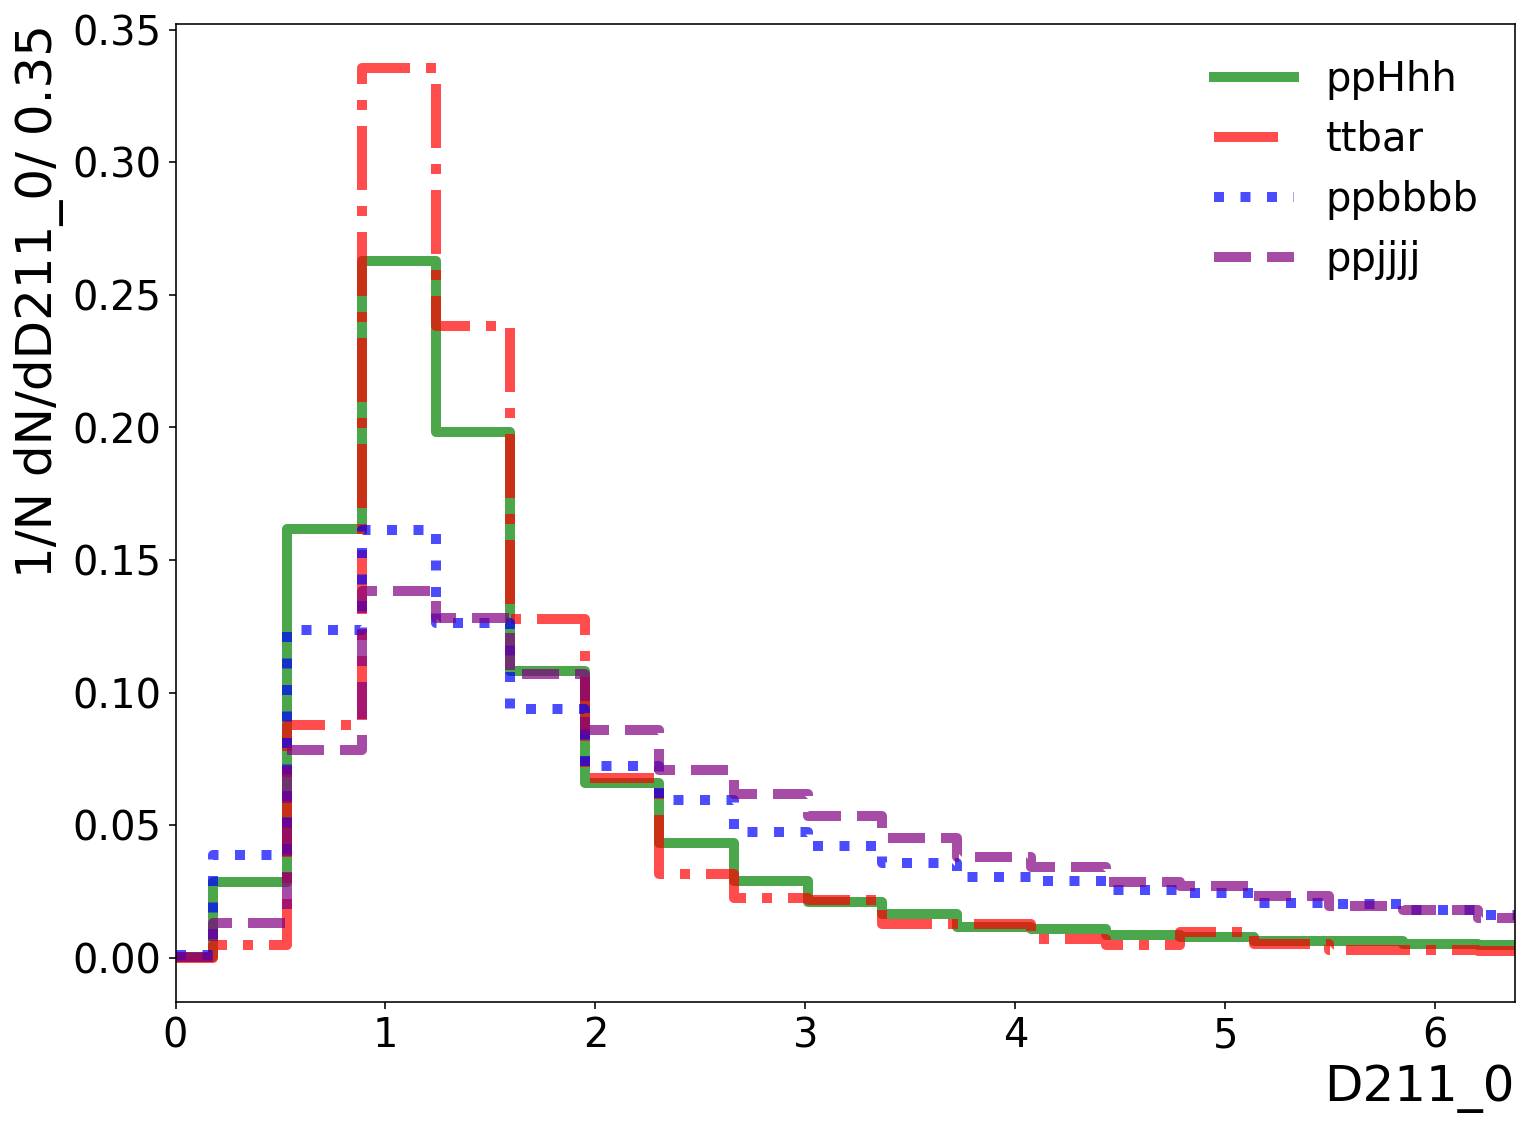

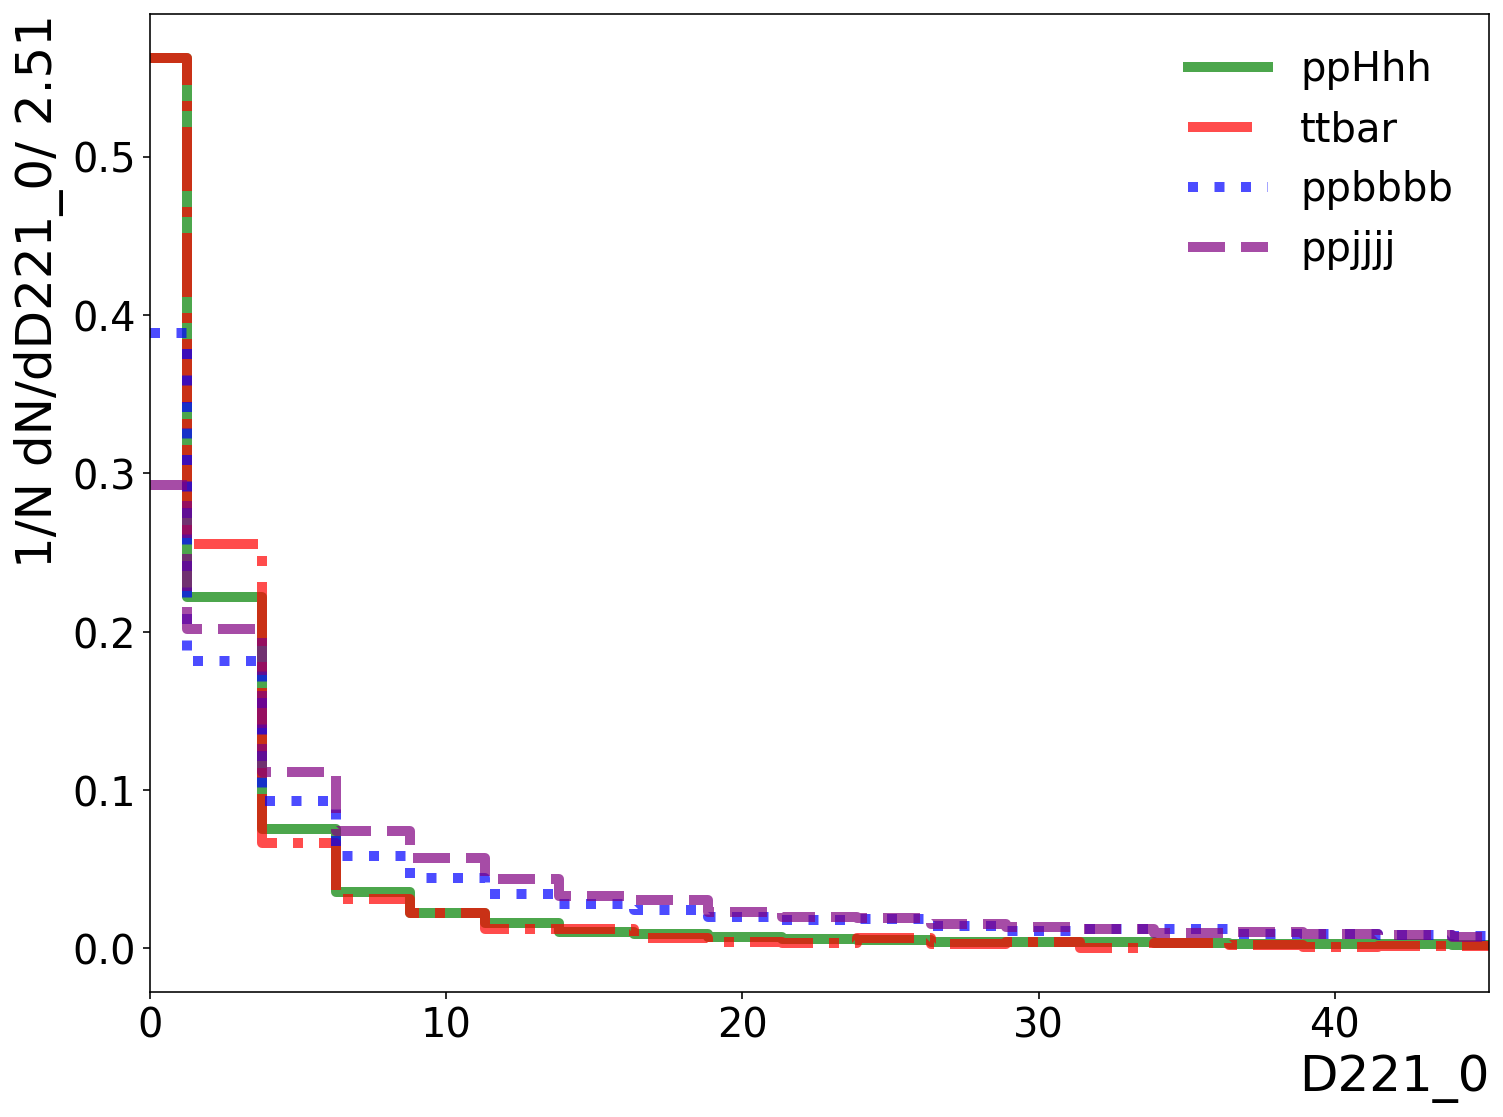

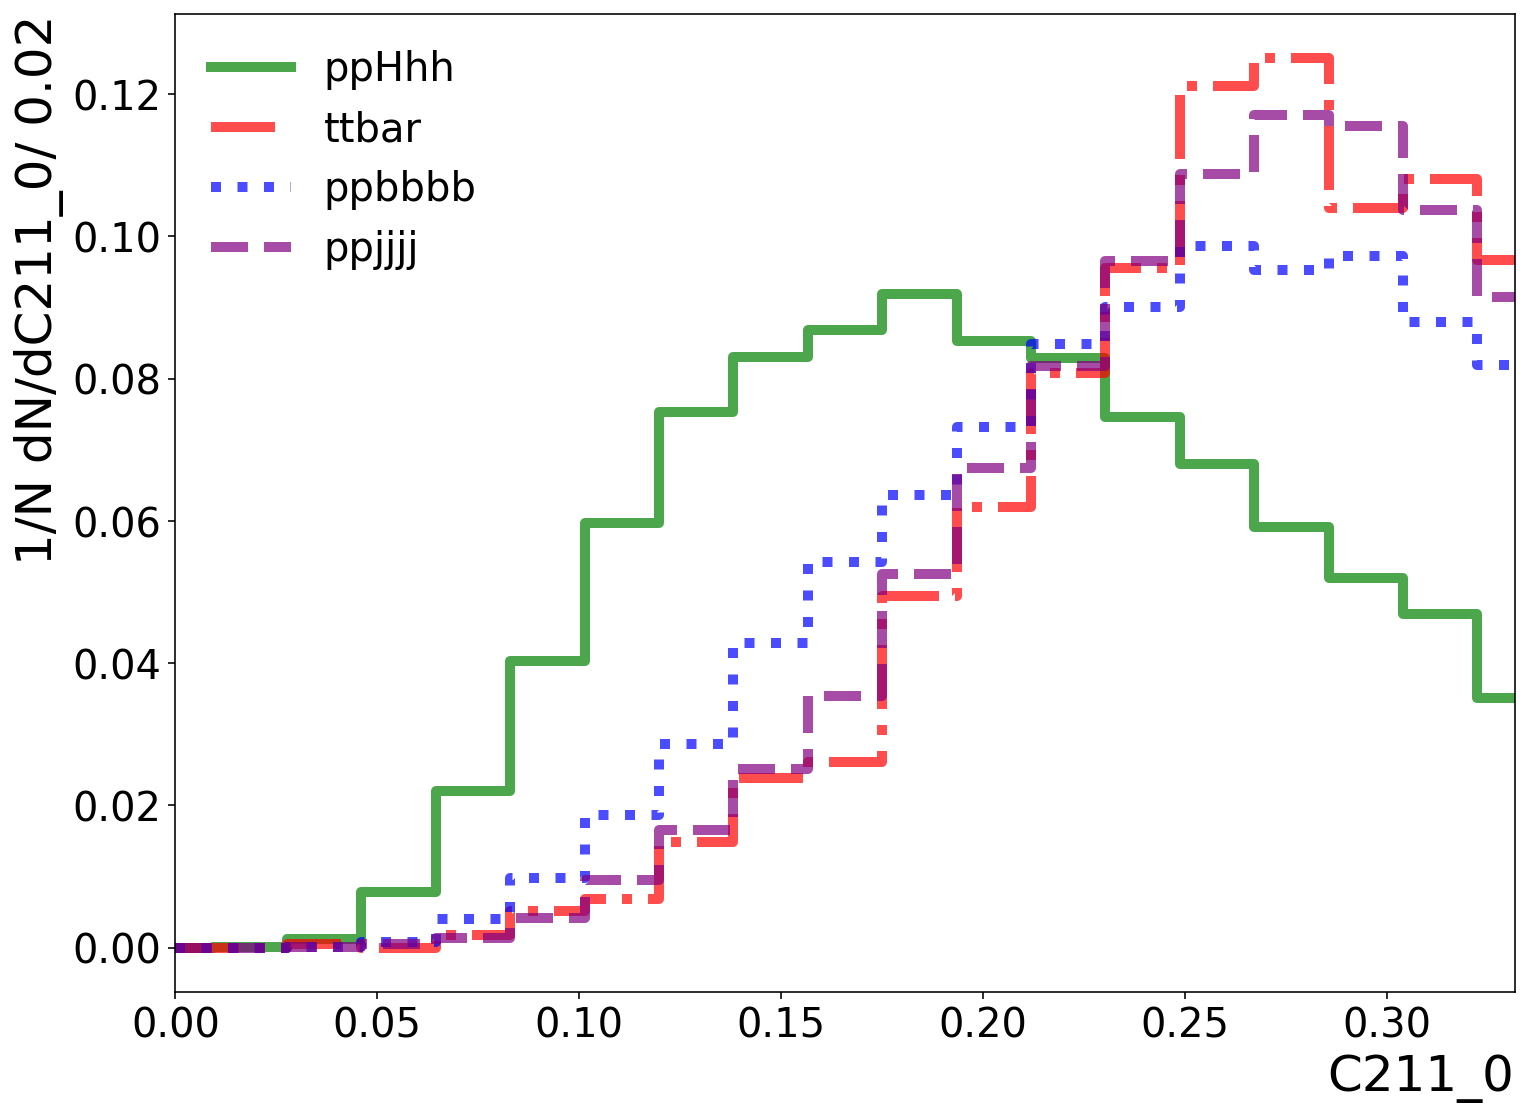

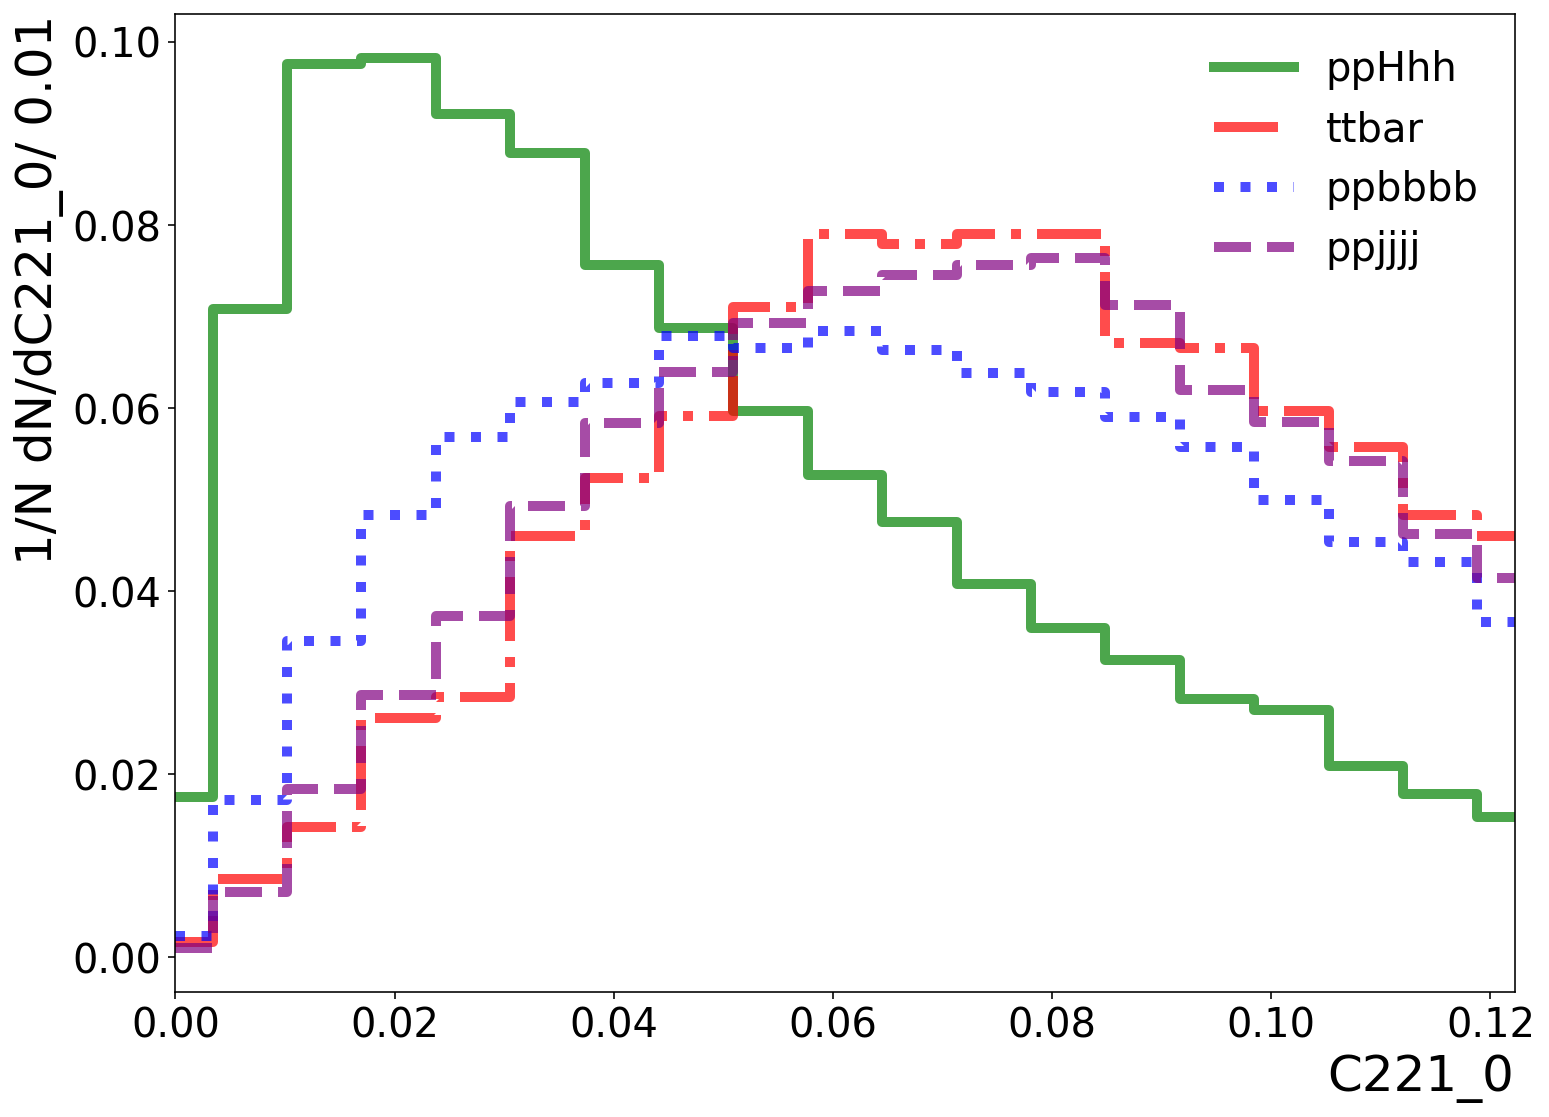

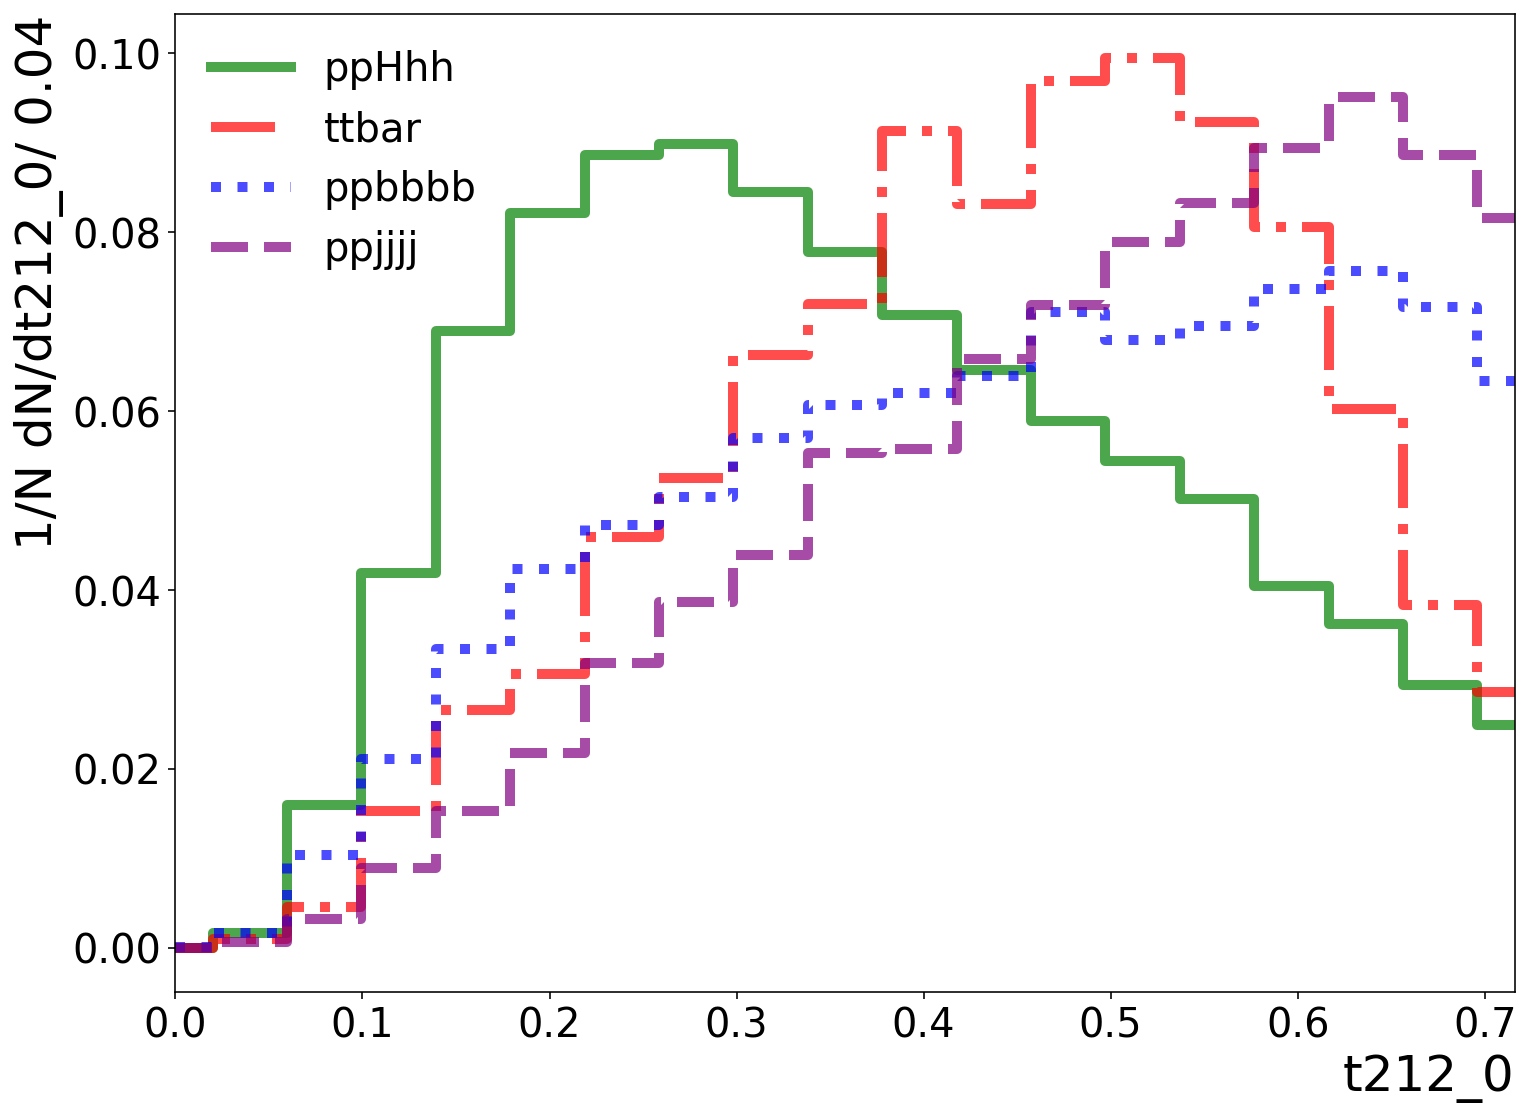

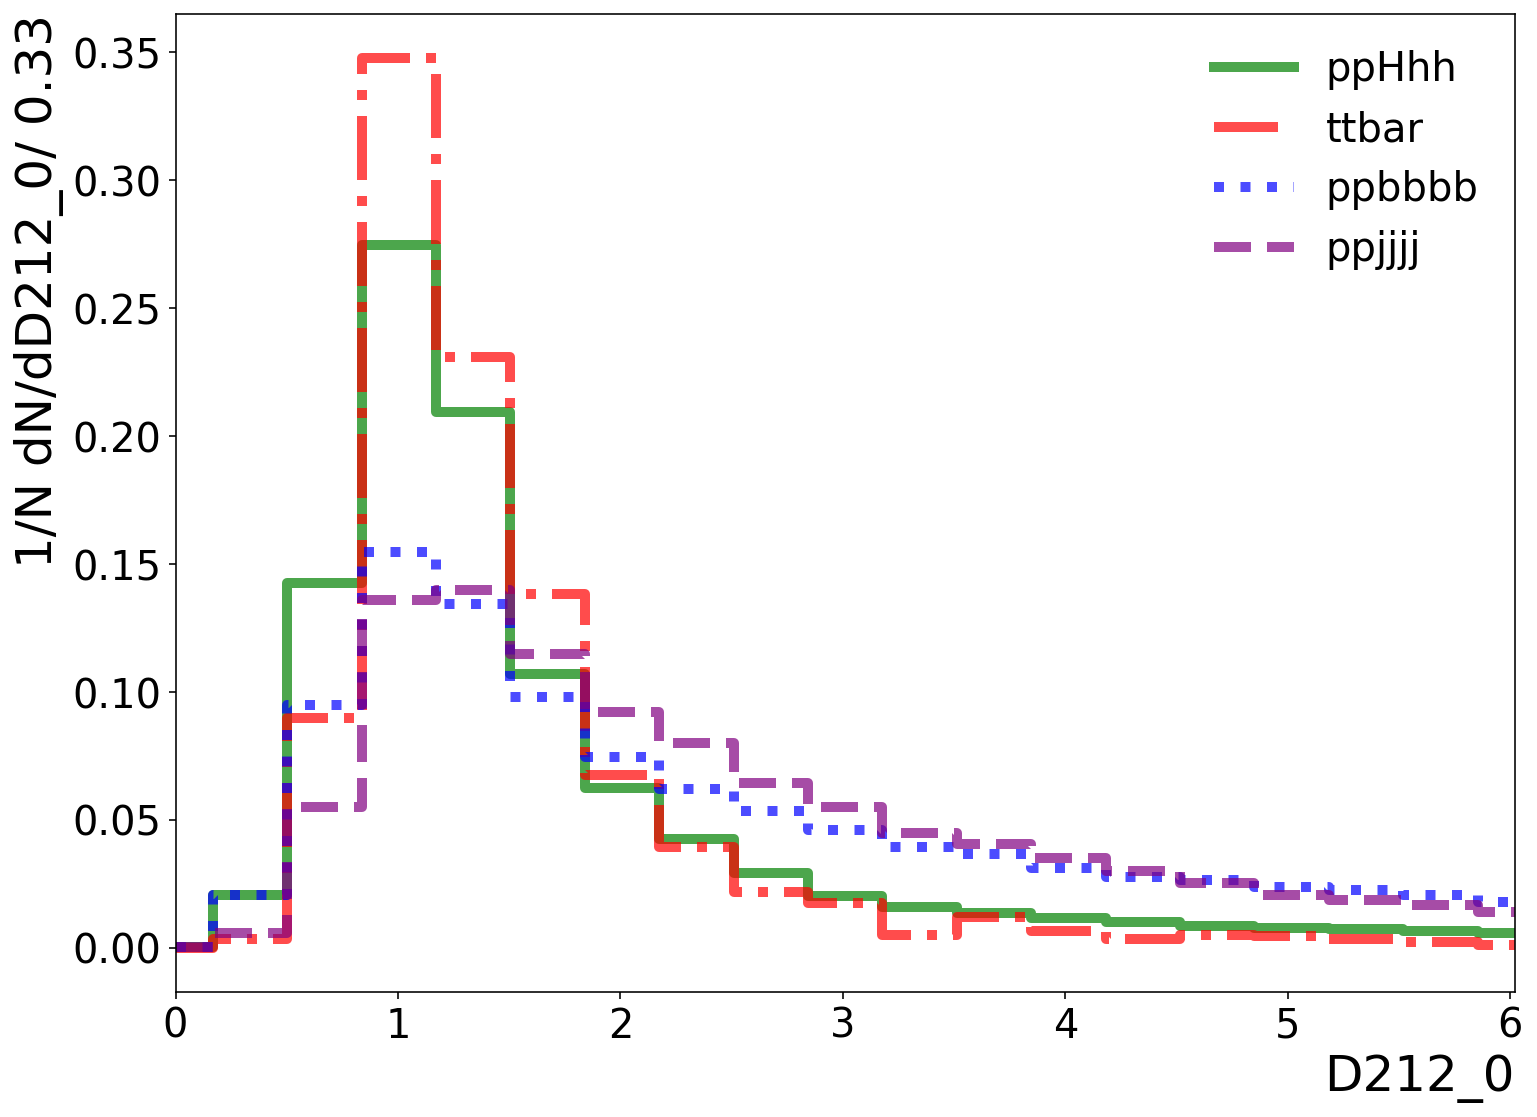

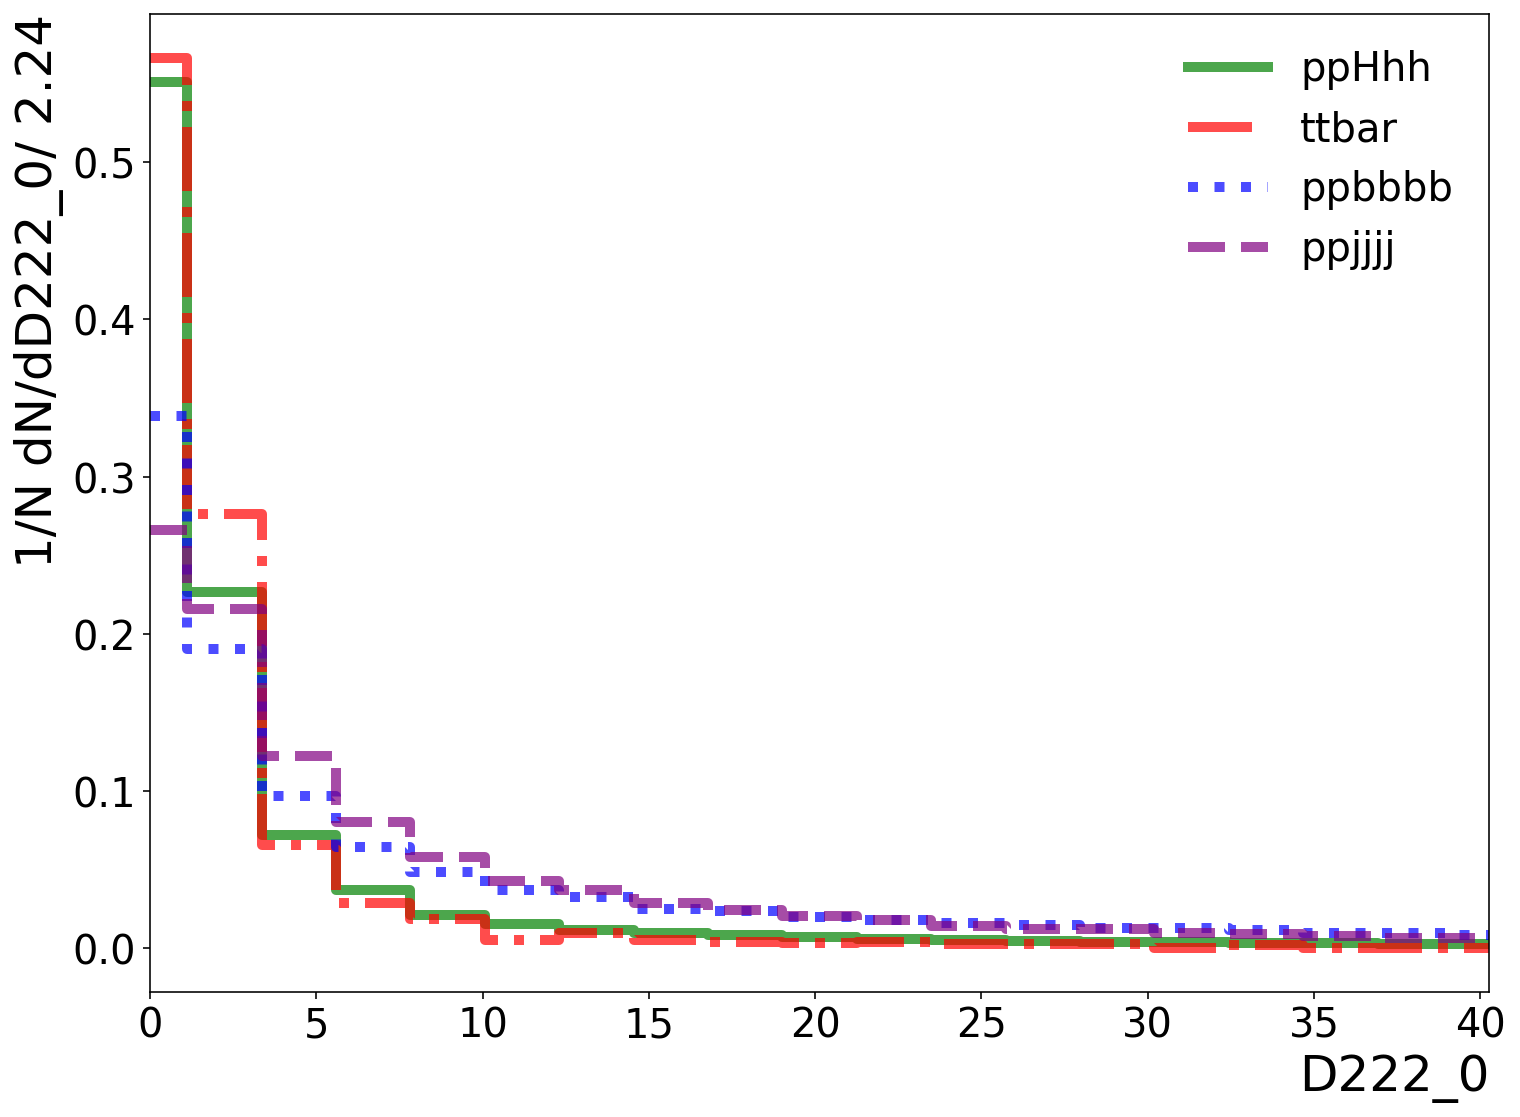

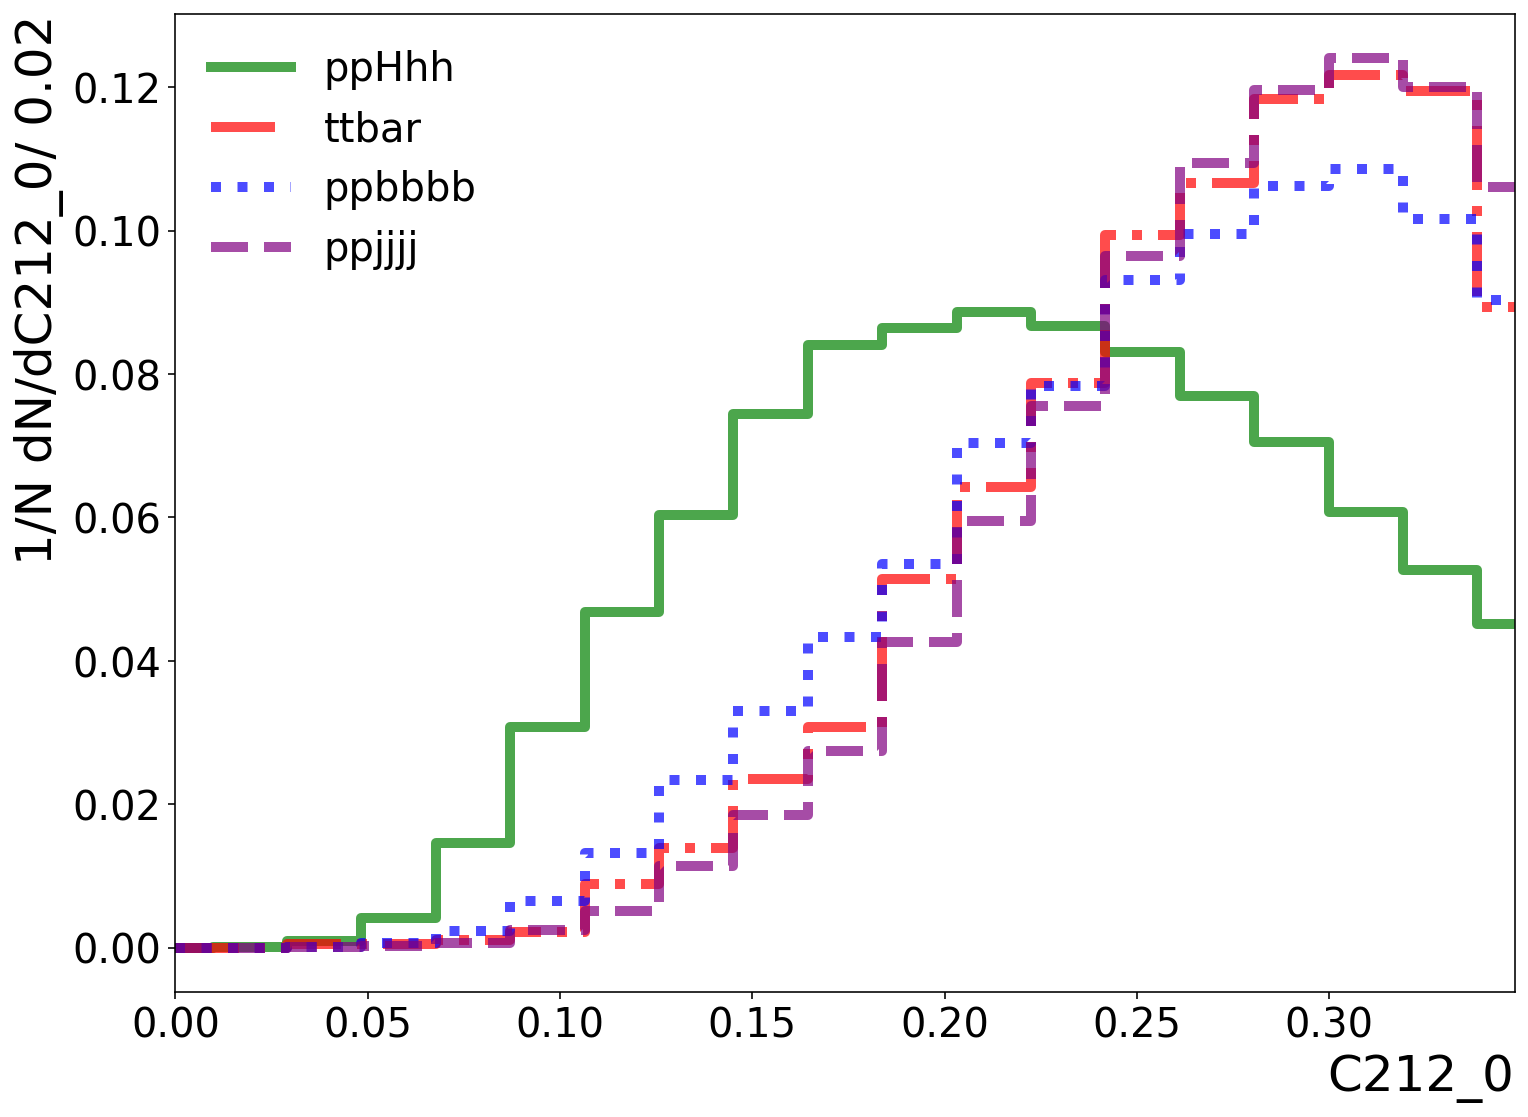

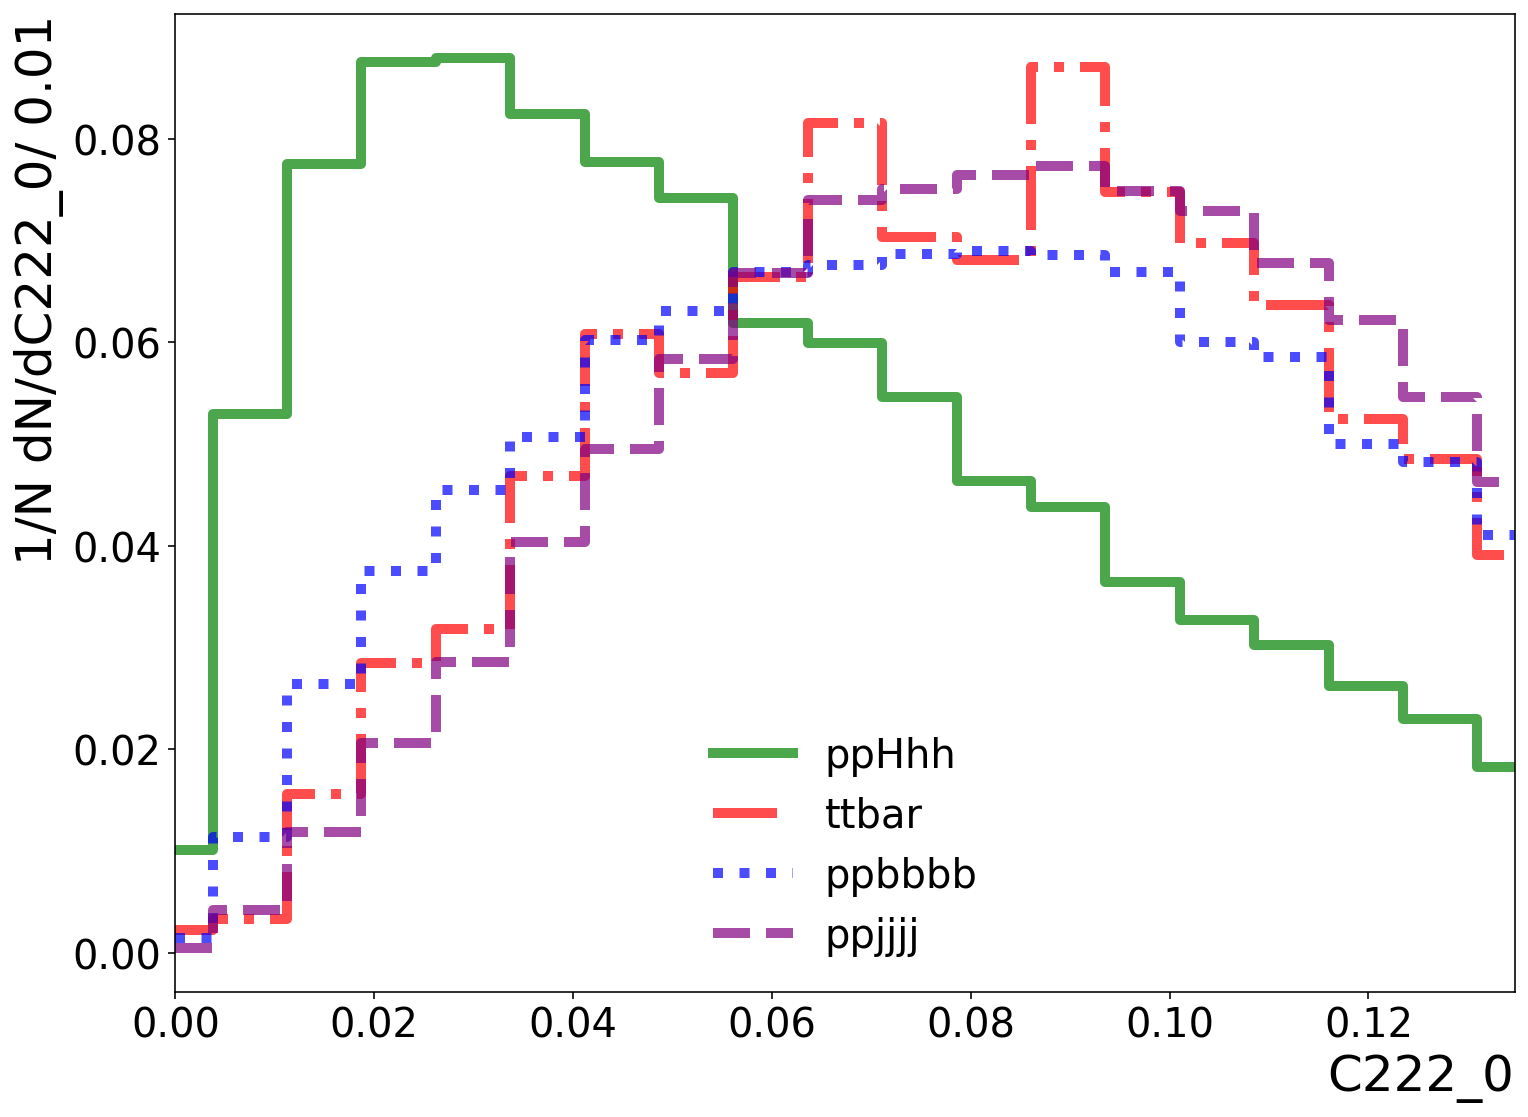

In [10]:
jet_substructure = [
                    "t211_0","D211_0","D221_0","C211_0","C221_0",
                    "t212_0","D212_0","D222_0","C212_0","C222_0"
                   ]
jet_substructure_name = [
                    "t211_0","D211_0","D221_0","C211_0","C221_0",
                    "t212_0","D212_0","D222_0","C212_0","C222_0"
                   ]


for index, jss in enumerate(jet_substructure):
    JSS= TotalSamples.Signal_Background(jss)


    fig, ax = plt.subplots(1,1, figsize=(12,9))
    for i, element in enumerate(JSS):

#         xmin, xmax = 0, np.max(process)
        xmin, xmax = 0, np.sort(JSS[0])[int(len(JSS[0])*19/20)]
        length = np.linspace(xmin,xmax,21)
        HIST(element, length, title,colors[i],linestyle[i])
        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)
        plt.xlim((0,xmax*0.9))
        plt.xlabel(jet_substructure_name[index], fontsize=25,horizontalalignment='right',x=1) 


    # plt.ylim((0.))
    unit = np.around(xmax/20, decimals=2)
    
    plt.ylabel("1/N dN/d" +jet_substructure_name[index]+ "/ "+str(unit), fontsize=25, horizontalalignment='right',y=1)
    # plt.savefig("./Plots/m_ww_parton.png", transparent=True, bbox_inches='tight')  #save figure as png
    plt.show()  

<a id="jets_in_nth_event"></a>
## Step 14: Print Jets in the Nth event

[Back to the top](#TOP)

In [ ]:
index = 0
N = 0

for i, jets in enumerate(process_list_clustered[index][N]):
    print("{}".format("No." +str(i)+" Jet's Information"))
    print(jets)
    print("-------------------------------------------------------------------------")
    print("{:^19} {:^20} ".format("Constituent's PID","Constituent's Four Momentum"))
    print("-------------------------------------------------------------------------")
    
    for constituent in jets: # get constituent in each "jet_element"
        print("{:^19} {} {:^19} ".format(int(constituent.PID), constituent, int(constituent.Charge)))
    print("-------------------------------------------------------------------------")

<a id="truth_record"></a>
## Step 15: Print the Truth Record in an Event


[Back to the top](#TOP)

In [88]:
%%time
GenParticle = BranchGenParticles(signal_ppHhh["file_1"])



CPU times: user 1min 3s, sys: 16.1 s, total: 1min 19s
Wall time: 1min 20s


In [91]:
%%time

print("There are {} information in this event.".format(len(GenParticle.Status[0])))
print("GenParticle Information")
print("{:^5}{:^7}{:^7}{:^7}{:^7}{:^7}{:^7}{:^8}{:^8}{:^8}{:^8}".format("#","Status","PID", "M1", "M2", "D1", "D2", "PT", "Eta","Phi", "Mass"))

index = 4 ## which event you want to logging.info out
k = 0
for j in range(len(GenParticle.Status_At(index))):
    
    if GenParticle.Status_At(index)[j] >= 21 and GenParticle.Status_At(index)[j] <= 29: 
    
#     if GenParticle.Status_At(index)[j] == 1: ##Selet the Stable Final State Particles
#         if np.abs(GenParticle.PID_At(index)[j]) == 12 or np.abs(GenParticle.PID_At(index)[j]) == 14:

#     if np.abs(GenParticle.PID_At(index)[GenParticle.M1_At(index)[j]]) == 24 or np.abs(GenParticle.PID_At(index)[GenParticle.M2_At(index)[j]]) == 24:
#         if np.abs(GenParticle.PID_At(index)[GenParticle.M1_At(index)[j]]) == 23 or np.abs(GenParticle.PID_At(index)[GenParticle.M2_At(index)[j]]) == 23:

        print("{:^5}{:^7}{:^7}{:^7}{:^7}{:^7}{:^7}{:^8.2}{:^8.2}{:^8.2}{:^8.2}".format( \
        j, GenParticle.Status_At(index)[j],  GenParticle.PID_At(index)[j], GenParticle.M1_At(index)[j], GenParticle.M2_At(index)[j],
         GenParticle.D1_At(index)[j], GenParticle.D2_At(index)[j],  GenParticle.PT_At(index)[j],  GenParticle.Eta_At(index)[j], GenParticle.Phi_At(index)[j], GenParticle.Mass_At(index)[j]))

#             k +=1
# logging.info(k)

There are 1010 information in this event.
GenParticle Information
  #  Status   PID    M1     M2     D1     D2      PT     Eta     Phi     Mass  
  0    21     21      4     -1      3      3     0.0    1e+03    0.0     0.0   
  1    21     21      6     -1      3      3     0.0    -1e+03   0.0     0.0   
  3    22     35      0      1      7      7     0.0    -1e+03   0.0    1e+03  
 520   22     25     412    -1     522    523  2.8e+02   -2.1    -2.5  1.3e+02 
 521   22     25     412    -1     542    543  2.2e+02   0.42    0.79  1.3e+02 
 522   23      5     520    -1     526    526  2.1e+02   -2.3    -2.6    4.7   
 523   23     -5     520    -1     524    525  7.2e+01   -1.3    -2.3    4.7   
 542   23      5     521    -1     544    545  2.6e+01  -0.78   -0.077   4.7   
 543   23     -5     521    -1     546    546   2e+02    0.55    0.89    4.7   
CPU times: user 42.2 ms, sys: 163 µs, total: 42.3 ms
Wall time: 40.8 ms
